# Numerics Exercise 2

# Summary
## Test Case 0
- Q is not constant where expected due to numerical diffusion of the solution caused by the upwind scheme. This causes the prescence of the wave spreading seen in the solution.
- The numerical scheme is first order accurate both temporally and spatially.
## Test Case 1
- The shock speed is observed slightly higher than the expected shock speed, at ~0.45m/s, with some variation with the altered inflow.
- The numerical scheme is again first order accurate both temporally and spatially.
## Test Case 2a
- Constant, steady state flow, Q, observed.
- Again, same accuracy as the other test cases.
## Test Case 2b
- The shock speed here is very close to the theoretical Rankine-Hugoniot shock speed, at 0.79m/s, being slightly higher but showing a similar time evolution.
- Again, same order of accuracy.
## Test Case 3
- Variable channel eliminates the shock occuring, causing a constant solution.
- Again, same order of accuracy

# Test Case 0

In [1]:
"""
1D St-Venant Kinematic River Flow - Test Cases 0 & 1
Optimized version with faster plotting
"""

import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
import time
from ufl import tanh as ufl_tanh
import os
os.environ["OMP_NUM_THREADS"] = "1"

def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
    """River width function with constrictions"""
    return w0 - 0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss))) \
           - 0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))

def run_simulation(test_case=0, Nx=2500, CFL=0.5, plot_results=True):
    """
    Run kinematic wave simulation
    
    Parameters:
    -----------
    test_case : int
        0: Test-Case-0 (constant inflow, rectangular profile)
        1: Test-Case-1 (flood hydrograph, rectangular profile)
        2: Test-Case-2a (constant inflow, compound channel)
        3: Test-Case-2b (flood hydrograph, compound channel)
    """
    
    # Physical parameters
    Lx = 5000.0
    grav = 9.81
    w0 = 100.0  # Flood plain width
    wb = 20.0   # Channel bed width
    hb = 4.0    # Channel depth
    H0 = 1.0    # Initial depth
    slope = -0.001
    sqrtmslope = np.sqrt(-slope)
    Cm = 0.1
    
    # Constriction parameters
    xo = 1000.0
    xa, xb = 1500.0 - xo, 1600.0 - xo
    xc, xd = 2000.0 - xo, 2200.0 - xo
    k1, k2 = 0.024, 0.027
    w1, w2 = 90.0, 80.0
    
    # Determine test case parameters
    if test_case in [0, 1]:
        nRP = 0  # Rectangular profile (simple)
        Tend = 3600.0 * 5
        Qmax = 350.0 if test_case == 1 else 0.0
        test_name = f"TC{test_case}"
    else:  # test_case in [2, 3]
        nRP = 1  # Compound channel (rectangular + flood plains)
        Tend = 3600.0 * 5
        Qmax = 350.0 if test_case == 3 else 0.0
        test_name = f"TC2{'b' if test_case == 3 else 'a'}"
    
    tmax = 0.5 * Tend
    gamfac = 0.000001
    
    # Mesh
    mesh = fd.IntervalMesh(Nx, Lx)
    x, = fd.SpatialCoordinate(mesh)
    dxx = Lx / Nx
    
    # Time step
    c00 = np.sqrt(grav * H0)
    dt = CFL * dxx / c00
    
    # Output parameters
    nmea = 16
    dtmeas = Tend / nmea
    
    # Function spaces
    DG0 = fd.FunctionSpace(mesh, "DG", 0)
    CG1 = fd.FunctionSpace(mesh, "CG", 4)
    
    # Functions
    A0 = fd.Function(DG0, name="A0")
    A1 = fd.Function(DG0, name="A1")
    wid0 = fd.Function(CG1, name="wid0")
    h00 = fd.Function(DG0, name="h00")
    FA00 = fd.Function(DG0, name="FA00")
    
    # Width function
    wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
    widL = wx
    
    # Constants for compound channel
    Ab = fd.Constant(wb * hb)
    wbb = fd.Constant(wb)
    hbb = fd.Constant(hb)
    
    # Initial conditions
    if nRP == 0:
        A0.interpolate(H0 * wx)
    else:  # nRP == 1
        A0.interpolate(H0 * wbb)
    wid0.interpolate(wx)
    
    # Test and trial functions
    A0_trial = fd.TrialFunction(DG0)
    A0_test = fd.TestFunction(DG0)
    
    # Mass matrix
    a_massA0 = A0_test * A0_trial * fd.dx
    
    # Facet normal
    n = fd.FacetNormal(mesh)
    
    # Boundary conditions
    widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
    
    if nRP == 0:
        A0left0 = H0 * widL0
        FA0left0 = sqrtmslope * A0left0**(5/3) / (widL0 + 2.0*A0left0/widL0)**(2/3) / Cm
    else:  # nRP == 1
        A0left0 = H0 * wb
        if A0left0 < hb * wb:
            FA0left0 = sqrtmslope * A0left0**(5/3) / (wb + 2.0*A0left0/wb)**(2/3) / Cm
        else:
            FA0left0 = sqrtmslope * A0left0**(5/3) / (wb + 2*hb + widL0 - wb + 2.0*(A0left0 - hb*wb)/widL0)**(2/3) / Cm
    
    A0left = fd.Constant(A0left0)
    FA0left = fd.Constant(FA0left0)
    
    # Flux function and derivatives
    A0avg = 0.5 * (A0('+') + A0('-'))
    
    if nRP == 0:
        # Simple rectangular channel
        FA0 = sqrtmslope * A0**(5/3) / (widL + 2.0*A0/widL)**(2/3) / Cm
        FA0fluxmin = sqrtmslope * A0('-')**(5/3) / (widL + 2.0*A0('-')/widL)**(2/3) / Cm
        FA0fluxplu = sqrtmslope * A0('+')**(5/3) / (widL + 2.0*A0('+')/widL)**(2/3) / Cm
        dFA0dA0 = (1/3) * sqrtmslope * A0avg**(2/3) * (5*widL + 6*A0avg/widL) / \
                  (widL + 2.0*A0avg/widL)**(5/3) / Cm
        dFA0dA0bnd = (1/3) * sqrtmslope * A0**(2/3) * (5*widL + 6*A0/widL) / \
                     (widL + 2.0*A0/widL)**(5/3) / Cm
    else:  # nRP == 1
        # Compound channel with rectangular section + flood plains
        FA0 = fd.conditional(
            A0 < Ab,
            sqrtmslope * A0**(5/3) / (wbb + 2.0*A0/wbb)**(2/3) / Cm,
            sqrtmslope * A0**(5/3) / (wbb + 2*hbb + widL - wbb + 2.0*(A0-Ab)/widL)**(2/3) / Cm
        )
        
        Peromi = fd.conditional(A0('-') < Ab, wbb + 2*A0('-')/wbb, 
                               wbb + 2*hbb + widL - wbb + 2*(A0('-')-Ab)/widL)
        Peripl = fd.conditional(A0('+') < Ab, wbb + 2*A0('+')/wbb,
                               wbb + 2*hbb + widL - wbb + 2*(A0('+')-Ab)/widL)
        
        FA0fluxmin = sqrtmslope * A0('-')**(5/3) / Peromi**(2/3) / Cm
        FA0fluxplu = sqrtmslope * A0('+')**(5/3) / Peripl**(2/3) / Cm
        
        dFA0dA0 = (sqrtmslope/(3*Cm)) * A0avg**(2/3) * fd.conditional(
            A0avg < Ab,
            (5*wbb + 6*A0avg/wbb) / (wbb + 2.0*A0avg/wbb)**(5/3),
            (5*(wbb + 2*hbb + widL - wbb - 2*Ab/widL) + 6*A0avg/widL) / 
            (wbb + 2*hbb + widL - wbb + 2*(A0avg-Ab)/widL)**(5/3)
        )
        
        dFA0dA0bnd = (sqrtmslope/(3*Cm)) * A0**(2/3) * fd.conditional(
            A0 < Ab,
            (5*wbb + 6*A0/wbb) / (wbb + 2.0*A0/wbb)**(5/3),
            (5*(wbb + 2*hbb + widL - wbb - 2*Ab/widL) + 6*A0/widL) / 
            (wbb + 2*hbb + widL - wbb + 2*(A0-Ab)/widL)**(5/3)
        )
    
    # Upwind flux
    FA0flux = fd.conditional(dFA0dA0*n[0]('+') > 0, FA0fluxplu, FA0fluxmin)
    FA0fluxbcl = fd.conditional((dFA0dA0bnd*n[0]) > 0, FA0left, FA0left)
    FA0fluxbcr = fd.conditional((dFA0dA0bnd*n[0]) > 0, FA0, FA0)
    
    # Variational form
    A0rhs = A0_test * A0 * fd.dx - dt * FA0flux * n[0]('+') * (A0_test('+') - A0_test('-')) * fd.dS
    A0rhs = A0rhs - dt * FA0fluxbcl * n[0] * A0_test * fd.ds(1) - dt * FA0fluxbcr * n[0] * A0_test * fd.ds(2)
    
    # Solver
    A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
    solver = fd.LinearVariationalSolver(A0_problem)
    
    # Storage
    times = []
    Q_inflow = []
    Q_outflow = []
    snapshot_times = []
    snapshot_h = []
    snapshot_A = []
    snapshot_Q = []
    
    # Sample points
    nx_plot = min(500, Nx)
    xvals = np.linspace(0.0, Lx, nx_plot)
    
    if plot_results:
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        tsize = 12
        axes[0].set_ylabel(r'$h(s,t)$ [m]', fontsize=tsize)
        axes[0].grid(True, alpha=0.3)
        axes[1].set_ylabel(r'$A(s,t)$ [m$^2$]', fontsize=tsize)
        axes[1].grid(True, alpha=0.3)
        axes[2].set_xlabel(r'$s$ [m]', fontsize=tsize)
        axes[2].set_ylabel(r'$Q(s,t)$ [m$^3$/s]', fontsize=tsize)
        axes[2].grid(True, alpha=0.3)
        
        # Also plot width
        w_vals = np.array([wid0.at(x) for x in xvals])
        axes[1].plot(xvals, w_vals * hb, 'k:', linewidth=1, alpha=0.5, label='Channel capacity')
    
    # Time integration
    print(f"\n{test_name}: Starting simulation")
    print(f"Nx = {Nx}, CFL = {CFL}, dt = {dt:.4f} s, Tend = {Tend:.0f} s")
    print(f"Channel: wb = {wb} m, hb = {hb} m, Flood plain width: w0 = {w0} m")
    
    t = 0.0
    nt = 0
    tmease = 0.0
    smallfac = 1e-10
    tic = time.time()
    
    while t < Tend:
        t += dt
        nt += 1
        
        # Update inflow
        if Qmax > 0:
            Q_in = FA0left0 + Qmax * np.exp(-gamfac * (t - tmax)**2)
            FA0left.assign(Q_in)
        else:
            Q_in = FA0left0
        
        # Solve
        solver.solve()
        A0.assign(A1)
        
        # Diagnostics at output times
        if t > tmease - smallfac or nt == 1:
            # Compute discharge and depth
            if nRP == 0:
                FA00.interpolate(FA0)
                h00.interpolate(A0 / widL)
            else:  # nRP == 1
                FA00.interpolate(FA0)
                h00.interpolate(fd.conditional(A0 < Ab, A0/wbb, hbb + (A0-Ab)/widL))
            
            Q_out = FA00.dat.data[-1]
            times.append(t)
            Q_inflow.append(Q_in)
            Q_outflow.append(Q_out)
        
        # Store snapshots
        if t > tmease - smallfac:
            tmease += dtmeas
            
            A_vals = np.array([A0.at(x) for x in xvals])
            h_vals = np.array([h00.at(x) for x in xvals])
            Q_vals = np.array([FA00.at(x) for x in xvals])
            
            snapshot_times.append(t)
            snapshot_h.append(h_vals)
            snapshot_A.append(A_vals)
            snapshot_Q.append(Q_vals)
            
            print(f"  t = {t:.1f} s (nt = {nt}), Q_in = {Q_in:.2f}, Q_out = {Q_out:.2f}")
    
    toc = time.time() - tic
    print(f"Completed in {toc/60:.2f} min ({nt} steps, {toc/nt*1000:.2f} ms/step)")
    
    # Plotting
    if plot_results:
        n_snapshots = len(snapshot_times)
        for i, t_snap in enumerate(snapshot_times):
            alpha = np.clip(0.4 + 0.6 * (i / n_snapshots), 0.0, 1.0)
            color = plt.cm.viridis(i / n_snapshots)
            
            if i == 0:
                axes[0].plot(xvals, snapshot_h[i], 'b-', linewidth=2, label='t=0')
                axes[1].plot(xvals, snapshot_A[i], 'b-', linewidth=2)
                axes[2].plot(xvals, snapshot_Q[i], 'b-', linewidth=2)
                if nRP == 1:
                    axes[0].axhline(hb, color='k', linestyle=':', linewidth=1, alpha=0.5)
            elif i == n_snapshots - 1:
                axes[0].plot(xvals, snapshot_h[i], 'r--', linewidth=2, label=f't={Tend:.0f}s')
                axes[1].plot(xvals, snapshot_A[i], 'r--', linewidth=2)
                axes[2].plot(xvals, snapshot_Q[i], 'r--', linewidth=2)
            else:
                axes[0].plot(xvals, snapshot_h[i], color=color, alpha=alpha, linewidth=1)
                axes[1].plot(xvals, snapshot_A[i], color=color, alpha=alpha, linewidth=1)
                axes[2].plot(xvals, snapshot_Q[i], color=color, alpha=alpha, linewidth=1)
        
        axes[0].legend()
        axes[0].set_title(f'{test_name}: Water Depth Evolution', fontsize=14)
        fig.tight_layout()
        fig.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_profiles.png", dpi=150)
        
        # Discharge time series
        fig2, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.array(times)/3600, Q_inflow, 'b-', linewidth=2, label='Inflow')
        ax.plot(np.array(times)/3600, Q_outflow, 'r-', linewidth=2, label='Outflow')
        ax.set_xlabel('Time [hours]', fontsize=12)
        ax.set_ylabel('Discharge [m$^3$/s]', fontsize=12)
        ax.set_title(f'{test_name}: Discharge Evolution', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
        fig2.tight_layout()
        fig2.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_discharge.png", dpi=150)
        
        # Analysis
        print(f"\n{test_name} Analysis:")
        print(f"  Initial Q_out: {Q_outflow[0]:.4f} m³/s")
        print(f"  Final Q_out:   {Q_outflow[-1]:.4f} m³/s")
        print(f"  Expected Q0:   {FA0left0:.4f} m³/s")
        
        if Qmax == 0:
            error = abs(Q_outflow[-1] - FA0left0) / FA0left0 * 100
            print(f"  Steady-state error: {error:.2f}%")
        else:
            # Shock analysis
            shock_analysis = compute_shock_speed(snapshot_times, snapshot_Q, snapshot_A, 
                                                xvals, test_name)
            if shock_analysis and shock_analysis['n_points'] >= 3:
                print(f"\nShock Speed Analysis:")
                print(f"  Observed speed:     {shock_analysis['observed_speed']:.4f} m/s")
                print(f"  Theoretical speed:  {shock_analysis['theoretical_speed']:.4f} m/s")
                print(f"  Relative error:     {shock_analysis['error']:.2f}%")
                print(f"  Shock at: s ≈ {shock_analysis['shock_location']:.1f} m, t ≈ {shock_analysis['shock_time']:.1f} s")
                print(f"  States: A_left = {shock_analysis['A_left']:.2f} m², A_right = {shock_analysis['A_right']:.2f} m²")
                print(f"  Fluxes: Q_left = {shock_analysis['Q_left']:.2f} m³/s, Q_right = {shock_analysis['Q_right']:.2f} m³/s")
                
                # Plot shock trajectory
                fig3, ax3 = plt.subplots(figsize=(8, 6))
                shock_t, shock_s = shock_analysis['shock_trajectory']
                ax3.plot(np.array(shock_t)/3600, shock_s, 'ko-', linewidth=2, markersize=4, label='Observed')
                
                # Theoretical line
                t_theory = np.array(shock_t)
                s_theory = shock_s[0] + shock_analysis['theoretical_speed'] * (t_theory - shock_t[0])
                ax3.plot(t_theory/3600, s_theory, 'r--', linewidth=2, label='Theoretical (RH)')
                
                ax3.set_xlabel('Time [hours]', fontsize=12)
                ax3.set_ylabel('Shock position [m]', fontsize=12)
                ax3.set_title(f'{test_name}: Shock Wave Trajectory', fontsize=14)
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                fig3.tight_layout()
                fig3.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_shock.png", dpi=150)
    
    return {
        'times': np.array(times),
        'Q_inflow': np.array(Q_inflow),
        'Q_outflow': np.array(Q_outflow),
        'Nx': Nx, 'dt': dt, 'CFL': CFL,
        'xvals': xvals,
        'snapshots': (snapshot_times, snapshot_h, snapshot_A, snapshot_Q)
    }


def convergence_analysis(test_case=0):
    """
    Perform spatial and temporal convergence analysis
    """
    print(f"\n{'='*60}")
    print(f"CONVERGENCE ANALYSIS FOR TEST CASE {test_case}")
    print(f"{'='*60}")
    
    # Spatial convergence (fixed CFL)
    Nx_values = [500, 1000, 2000, 4000]
    CFL_fixed = 0.5
    
    print(f"\nSpatial Convergence (CFL = {CFL_fixed}):")
    print("-" * 60)
    
    results_spatial = []
    Q_final = []
    dx_values = []
    
    for Nx in Nx_values:
        result = run_simulation(test_case=test_case, Nx=Nx, CFL=CFL_fixed, plot_results=False)
        results_spatial.append(result)
        Q_final.append(result['Q_outflow'][-1])
        dx_values.append(5000.0 / Nx)
        print(f"Nx = {Nx:4d}, dx = {dx_values[-1]:.4f}: "
              f"Q_out(final) = {Q_final[-1]:.4f} m³/s")
    
    # Estimate convergence rate
    if len(Q_final) >= 2:
        print("\nConvergence rates (between consecutive resolutions):")
        for i in range(len(Q_final) - 1):
            error1 = abs(Q_final[i] - Q_final[-1])
            error2 = abs(Q_final[i+1] - Q_final[-1])
            if error1 > 1e-10 and error2 > 1e-10:
                rate = np.log(error1 / error2) / np.log(dx_values[i] / dx_values[i+1])
                print(f"  Nx {Nx_values[i]} -> {Nx_values[i+1]}: rate ≈ {rate:.2f}")
    
    # Temporal convergence (fixed Nx)
    CFL_values = [0.25, 0.5, 1.0]
    Nx_fixed = 2000
    
    print(f"\nTemporal Convergence (Nx = {Nx_fixed}):")
    print("-" * 60)
    
    results_temporal = []
    Q_final_temp = []
    dt_values = []
    
    for CFL in CFL_values:
        result = run_simulation(test_case=test_case, Nx=Nx_fixed, CFL=CFL, plot_results=False)
        results_temporal.append(result)
        Q_final_temp.append(result['Q_outflow'][-1])
        dt_values.append(result['dt'])
        print(f"CFL = {CFL:.2f}, dt = {dt_values[-1]:.6f}: "
              f"Q_out(final) = {Q_final_temp[-1]:.4f} m³/s")
    
    return results_spatial, results_temporal


TEST CASE 0: Constant inflow


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(



TC0: Starting simulation
Nx = 2500, CFL = 0.5, dt = 0.3193 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.3 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.1 s (nt = 3524), Q_in = 31.21, Q_out = 31.21
  t = 2250.3 s (nt = 7048), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 10571), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 5625.3 s (nt = 17619), Q_in = 31.21, Q_out = 31.21
  t = 6750.1 s (nt = 21142), Q_in = 31.21, Q_out = 31.21
  t = 7875.2 s (nt = 24666), Q_in = 31.21, Q_out = 25.69
  t = 9000.1 s (nt = 28189), Q_in = 31.21, Q_out = 25.44
  t = 10125.2 s (nt = 31713), Q_in = 31.21, Q_out = 31.21
  t = 11250.3 s (nt = 35237), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 38760), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 42284), Q_in = 31.21, Q_out = 31.21
  t = 14625.0 s (nt = 45807), Q_in = 31.21, Q_out = 31.21
  t = 15750.2 s (nt = 49331), Q_in = 31.21, Q_out = 31.21
  t = 16875.3 s (nt = 52855), Q_in = 31.21, Q_out = 31.21
  t = 18000.1 s (nt = 56378), Q_in = 31.21, Q_out = 31.21
Completed in 2.45 min (56378 ste

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 1.6 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.4 s (nt = 705), Q_in = 31.21, Q_out = 31.21
  t = 2250.9 s (nt = 1410), Q_in = 31.21, Q_out = 31.21
  t = 3376.3 s (nt = 2115), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 5625.6 s (nt = 3524), Q_in = 31.21, Q_out = 31.21
  t = 6751.1 s (nt = 4229), Q_in = 31.21, Q_out = 30.86
  t = 7876.5 s (nt = 4934), Q_in = 31.21, Q_out = 25.20
  t = 9000.4 s (nt = 5638), Q_in = 31.21, Q_out = 25.98
  t = 10125.8 s (nt = 6343), Q_in = 31.21, Q_out = 31.20
  t = 11251.3 s (nt = 7048), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 7752), Q_in = 31.21, Q_out = 31.21
  t = 13500.6 s (nt = 8457), Q_in = 31.21, Q_out = 31.21
  t = 14626.0 s (nt = 9162), Q_in = 31.21, Q_out = 31.21
  t = 15751.5 s (nt = 9867), Q_in = 31.21, Q_out = 31.21
  t = 16875.3 s (nt = 10571), Q_in = 31.21, Q_out = 31.21
  t = 18000.7 s (nt = 11276), Q_in = 31.21, Q_out = 31.21
Completed in 0.25 min (11276 steps, 1.31 ms/s

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.8 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.4 s (nt = 1410), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 3375.5 s (nt = 4229), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 5625.6 s (nt = 7048), Q_in = 31.21, Q_out = 31.21
  t = 6750.3 s (nt = 8457), Q_in = 31.21, Q_out = 31.13
  t = 7875.7 s (nt = 9867), Q_in = 31.21, Q_out = 25.46
  t = 9000.4 s (nt = 11276), Q_in = 31.21, Q_out = 25.38
  t = 10125.0 s (nt = 12685), Q_in = 31.21, Q_out = 31.21
  t = 11250.5 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 15504), Q_in = 31.21, Q_out = 31.21
  t = 13500.6 s (nt = 16914), Q_in = 31.21, Q_out = 31.21
  t = 14625.2 s (nt = 18323), Q_in = 31.21, Q_out = 31.21
  t = 15750.7 s (nt = 19733), Q_in = 31.21, Q_out = 31.21
  t = 16875.3 s (nt = 21142), Q_in = 31.21, Q_out = 31.21
  t = 18000.7 s (nt = 22552), Q_in = 31.21, Q_out = 31.21
Completed in 0.61 min (22552 steps, 1

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.0 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 8457), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 11276), Q_in = 31.21, Q_out = 31.21
  t = 5625.2 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 6750.3 s (nt = 16914), Q_in = 31.21, Q_out = 31.20
  t = 7875.3 s (nt = 19733), Q_in = 31.21, Q_out = 25.65
  t = 9000.4 s (nt = 22552), Q_in = 31.21, Q_out = 25.40
  t = 10125.0 s (nt = 25370), Q_in = 31.21, Q_out = 31.21
  t = 11250.1 s (nt = 28189), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 31008), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 33827), Q_in = 31.21, Q_out = 31.21
  t = 14625.2 s (nt = 36646), Q_in = 31.21, Q_out = 31.21
  t = 15750.3 s (nt = 39465), Q_in = 31.21, Q_out = 31.21
  t = 16875.3 s (nt = 42284), Q_in = 31.21, Q_out = 31.21
  t = 18000.3 s (nt = 45103), Q_in = 31.21, Q_out = 31.21
Completed in 1.73 min (45103 step

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.2 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.0 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 11276), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 16914), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 22552), Q_in = 31.21, Q_out = 31.21
  t = 5625.0 s (nt = 28189), Q_in = 31.21, Q_out = 31.21
  t = 6750.1 s (nt = 33827), Q_in = 31.21, Q_out = 31.21
  t = 7875.1 s (nt = 39465), Q_in = 31.21, Q_out = 25.75
  t = 9000.2 s (nt = 45103), Q_in = 31.21, Q_out = 25.49
  t = 10125.0 s (nt = 50740), Q_in = 31.21, Q_out = 31.21
  t = 11250.1 s (nt = 56378), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 62016), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 67654), Q_in = 31.21, Q_out = 31.21
  t = 14625.0 s (nt = 73291), Q_in = 31.21, Q_out = 31.21
  t = 15750.1 s (nt = 78929), Q_in = 31.21, Q_out = 31.21
  t = 16875.1 s (nt = 84567), Q_in = 31.21, Q_out = 31.21
  t = 18000.2 s (nt = 90205), Q_in = 31.21, Q_out = 31.21
Completed in 5.60 min (90205 st

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 6750.1 s (nt = 33827), Q_in = 31.21, Q_out = 31.20
  t = 7875.1 s (nt = 39465), Q_in = 31.21, Q_out = 25.65
  t = 9000.2 s (nt = 45103), Q_in = 31.21, Q_out = 25.40
  t = 10125.0 s (nt = 50740), Q_in = 31.21, Q_out = 31.21
  t = 11250.1 s (nt = 56378), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 62016), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 67654), Q_in = 31.21, Q_out = 31.21
  t = 14625.0 s (nt = 73291), Q_in = 31.21, Q_out = 31.21
  t = 15750.1 s (nt = 78929), Q_in = 31.21, Q_out = 31.21
  t = 16875.1 s (nt = 84567), Q_in = 31.21, Q_out = 31.21
  t = 18000.2 s (nt = 90205), Q_in = 31.21, Q_out = 31.21
Completed in 3.29 min (90205 steps, 2.19 ms/step)
CFL = 0.25, dt = 0.199547: Q_out(final) = 31.2080 m³/s

TC0: Starting simulation
Nx = 2000, CFL = 0.5, dt = 0.3991 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.0 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 8457), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 11276), Q_in = 31.21, Q_out = 31.21
  t = 5625.2 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 6750.3 s (nt = 16914), Q_in = 31.21, Q_out = 31.20
  t = 7875.3 s (nt = 19733), Q_in = 31.21, Q_out = 25.65
  t = 9000.4 s (nt = 22552), Q_in = 31.21, Q_out = 25.40
  t = 10125.0 s (nt = 25370), Q_in = 31.21, Q_out = 31.21
  t = 11250.1 s (nt = 28189), Q_in = 31.21, Q_out = 31.21
  t = 12375.1 s (nt = 31008), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 33827), Q_in = 31.21, Q_out = 31.21
  t = 14625.2 s (nt = 36646), Q_in = 31.21, Q_out = 31.21
  t = 15750.3 s (nt = 39465), Q_in = 31.21, Q_out = 31.21
  t = 16875.3 s (nt = 42284), Q_in = 31.21, Q_out = 31.21
  t = 18000.3 s (nt = 45103), Q_in = 31.21, Q_out = 31.21
Completed in 1.67 min (45103 step

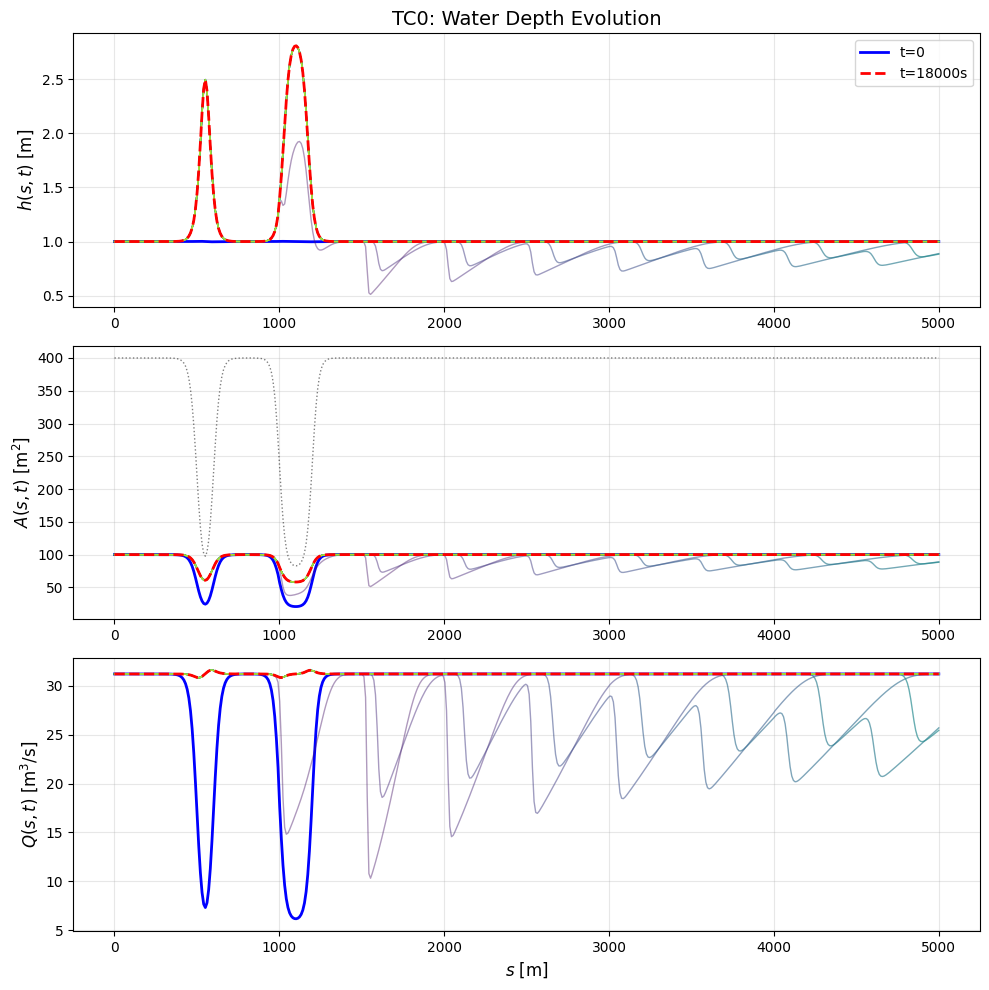

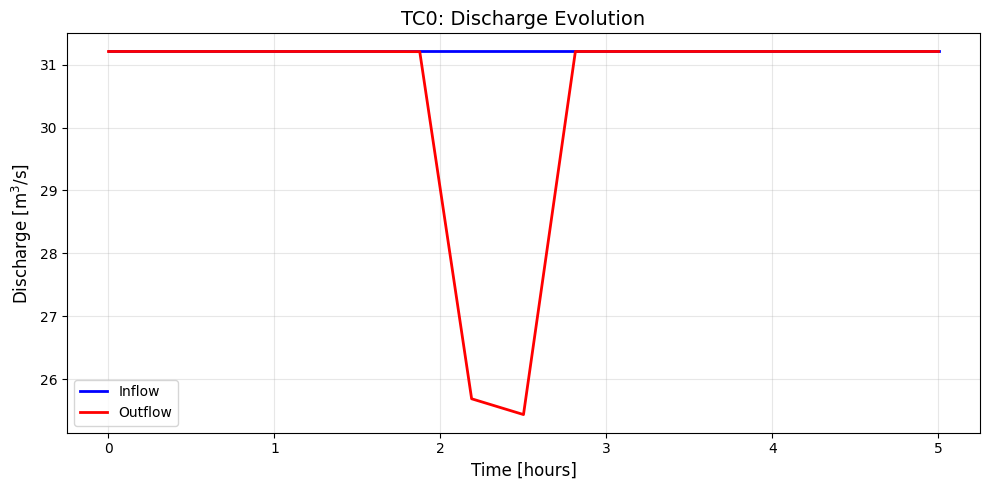


SIMULATION COMPLETED


In [2]:
if __name__ == "__main__":
    # Run Test-Case-0: Steady state
    print("\n" + "="*70)
    print("TEST CASE 0: Constant inflow")
    print("="*70)
    result_tc0 = run_simulation(test_case=0, Nx=2500, CFL=0.5, plot_results=True)
    
    # Convergence analysis
    print("\n" + "="*70)
    convergence_analysis(test_case=0)
   
    plt.show()
    print("\n" + "="*70)
    print("SIMULATION COMPLETED")
    print("="*70)

- The upwind finite volume scheme introduces numerical diffusion of the solution, causing the wave spreading seen in the solution.
- The scheme is first order accurate in both space and time.

# Test Case 1


TEST CASE 1: Flood hydrograph

TC1: Starting simulation
Nx = 2500, CFL = 0.5, dt = 0.3193 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m
  t = 0.3 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.1 s (nt = 3524), Q_in = 31.21, Q_out = 31.21
  t = 2250.3 s (nt = 7048), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 10571), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 5625.3 s (nt = 17619), Q_in = 31.21, Q_out = 31.21
  t = 6750.1 s (nt = 21142), Q_in = 33.42, Q_out = 31.21
  t = 7875.2 s (nt = 24666), Q_in = 129.99, Q_out = 25.69
  t = 9000.1 s (nt = 28189), Q_in = 381.21, Q_out = 25.44
  t = 10125.2 s (nt = 31713), Q_in = 129.89, Q_out = 31.21
  t = 11250.3 s (nt = 35237), Q_in = 33.42, Q_out = 31.21
  t = 12375.1 s (nt = 38760), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 42284), Q_in = 31.21, Q_out = 307.70
  t = 14625.0 s (nt = 45807), Q_in = 31.21, Q_out = 193.37
  t = 15750.2 s (nt = 4933

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 1.6 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.4 s (nt = 705), Q_in = 31.21, Q_out = 31.21
  t = 2250.9 s (nt = 1410), Q_in = 31.21, Q_out = 31.21
  t = 3376.3 s (nt = 2115), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 5625.6 s (nt = 3524), Q_in = 31.21, Q_out = 31.21
  t = 6751.1 s (nt = 4229), Q_in = 33.43, Q_out = 30.86
  t = 7876.5 s (nt = 4934), Q_in = 130.27, Q_out = 25.20
  t = 9000.4 s (nt = 5638), Q_in = 381.21, Q_out = 25.98
  t = 10125.8 s (nt = 6343), Q_in = 129.75, Q_out = 31.20
  t = 11251.3 s (nt = 7048), Q_in = 33.41, Q_out = 31.21
  t = 12375.1 s (nt = 7752), Q_in = 31.21, Q_out = 31.21
  t = 13500.6 s (nt = 8457), Q_in = 31.21, Q_out = 306.62
  t = 14626.0 s (nt = 9162), Q_in = 31.21, Q_out = 193.23
  t = 15751.5 s (nt = 9867), Q_in = 31.21, Q_out = 124.00
  t = 16875.3 s (nt = 10571), Q_in = 31.21, Q_out = 83.65
  t = 18000.7 s (nt = 11276), Q_in = 31.21, Q_out = 59.33
Completed in 0.25 min (11276 steps, 1.3

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.0 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 3375.1 s (nt = 8457), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 11276), Q_in = 31.21, Q_out = 31.21
  t = 5625.2 s (nt = 14095), Q_in = 31.21, Q_out = 31.21
  t = 6750.3 s (nt = 16914), Q_in = 33.43, Q_out = 31.20
  t = 7875.3 s (nt = 19733), Q_in = 130.00, Q_out = 25.65
  t = 9000.4 s (nt = 22552), Q_in = 381.21, Q_out = 25.40
  t = 10125.0 s (nt = 25370), Q_in = 129.93, Q_out = 31.21
  t = 11250.1 s (nt = 28189), Q_in = 33.42, Q_out = 31.21
  t = 12375.1 s (nt = 31008), Q_in = 31.21, Q_out = 31.21
  t = 13500.2 s (nt = 33827), Q_in = 31.21, Q_out = 307.65
  t = 14625.2 s (nt = 36646), Q_in = 31.21, Q_out = 193.35
  t = 15750.3 s (nt = 39465), Q_in = 31.21, Q_out = 123.90
  t = 16875.3 s (nt = 42284), Q_in = 31.21, Q_out = 83.43
  t = 18000.3 s (nt = 45103), Q_in = 31.21, Q_out = 59.09
Completed in 1.68 min (4510

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.8 s (nt = 1), Q_in = 31.21, Q_out = 31.21
  t = 1125.4 s (nt = 1410), Q_in = 31.21, Q_out = 31.21
  t = 2250.1 s (nt = 2819), Q_in = 31.21, Q_out = 31.21
  t = 3375.5 s (nt = 4229), Q_in = 31.21, Q_out = 31.21
  t = 4500.2 s (nt = 5638), Q_in = 31.21, Q_out = 31.21
  t = 5625.6 s (nt = 7048), Q_in = 31.21, Q_out = 31.21
  t = 6750.3 s (nt = 8457), Q_in = 33.43, Q_out = 31.20
  t = 7875.7 s (nt = 9867), Q_in = 130.09, Q_out = 25.66
  t = 9000.4 s (nt = 11276), Q_in = 381.21, Q_out = 25.41
  t = 10125.0 s (nt = 12685), Q_in = 129.93, Q_out = 31.21
  t = 11250.5 s (nt = 14095), Q_in = 33.42, Q_out = 31.21
  t = 12375.1 s (nt = 15504), Q_in = 31.21, Q_out = 31.21
  t = 13500.6 s (nt = 16914), Q_in = 31.21, Q_out = 307.60
  t = 14625.2 s (nt = 18323), Q_in = 31.21, Q_out = 193.29
  t = 15750.7 s (nt = 19733), Q_in = 31.21, Q_out = 123.83
  t = 16875.3 s (nt = 21142), Q_in = 31.21, Q_out = 83.40
  t = 18000.7 s (nt = 22552), Q_in = 31.21, Q_out = 59.06
Completed in 0.90 min (22552 st

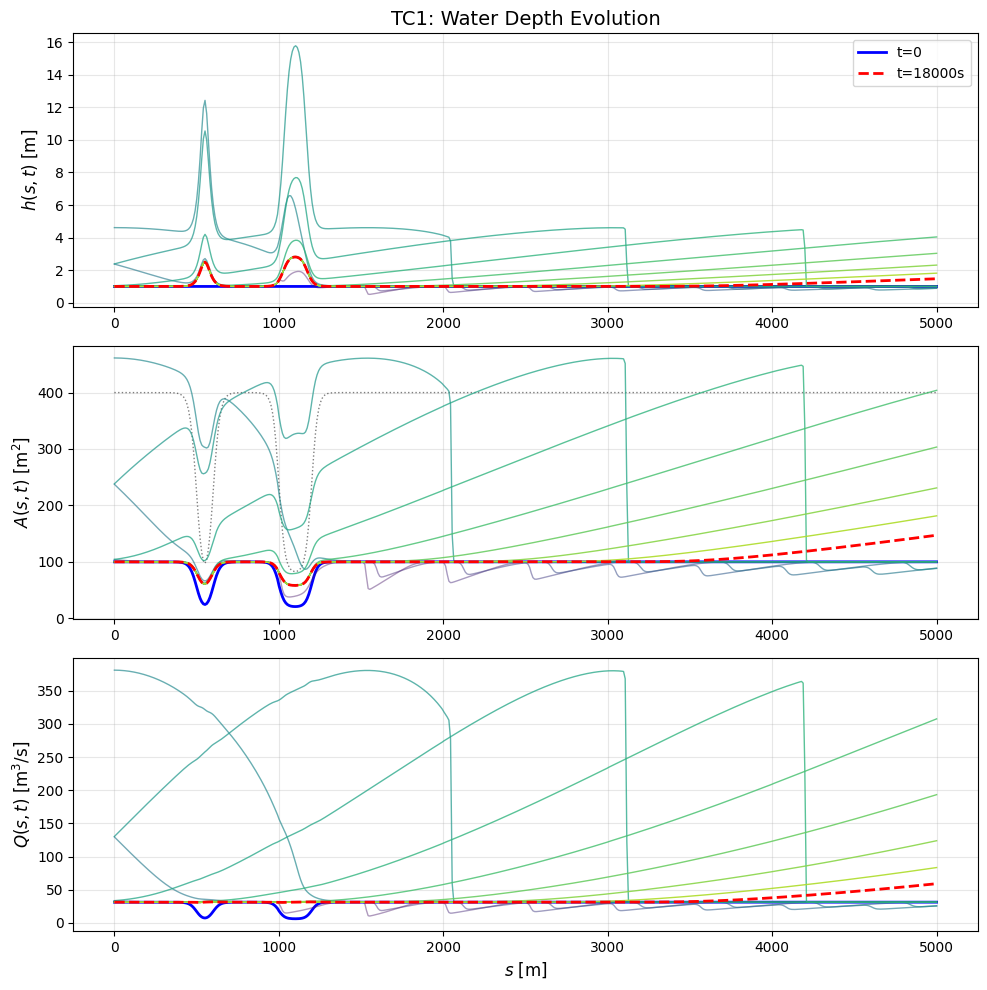

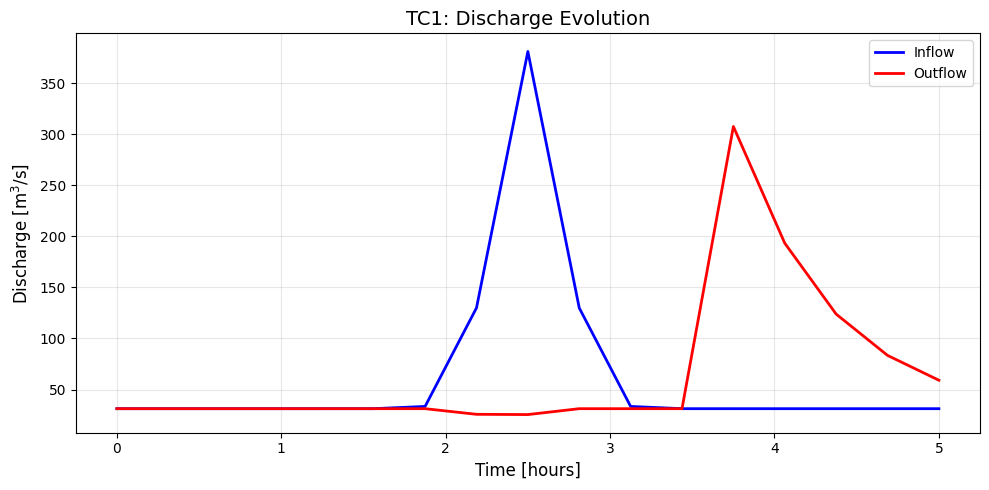

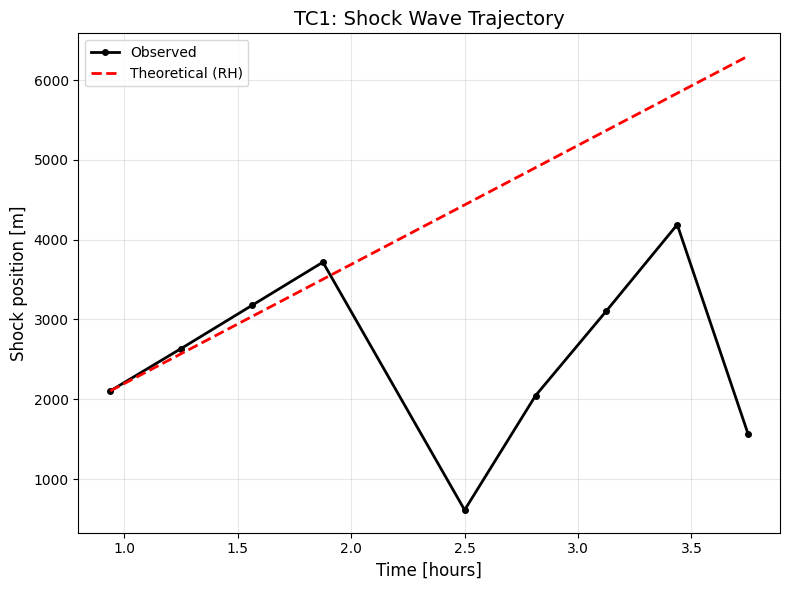


SIMULATION COMPLETED


In [3]:
def compute_shock_speed(times, Q_snapshots, A_snapshots, xvals, test_case_name):
    """
    Compute shock speed using Rankine-Hugoniot conditions for kinematic wave
    
    For kinematic wave: ∂A/∂t + ∂F(A)/∂s = 0
    RH condition: s_shock = (F_left - F_right) / (A_left - A_right)
    """
    if len(times) < 5:
        return None
    
    # Track shock through snapshots
    shock_locations = []
    shock_times_obs = []
    shock_A_left = []
    shock_A_right = []
    shock_Q_left = []
    shock_Q_right = []
    
    # Use middle portion of simulation
    start_idx = max(2, len(times) // 5)
    end_idx = min(len(times) - 2, 4 * len(times) // 5)
    
    for i in range(start_idx, end_idx):
        A_snap = A_snapshots[i]
        Q_snap = Q_snapshots[i]
        
        # Find shock by maximum gradient in Q (more visible than A)
        dQ_ds = np.gradient(Q_snap, xvals)
        
        # Find steepest gradient
        abs_grad = np.abs(dQ_ds)
        threshold = 0.3 * np.max(abs_grad)
        shock_candidates = np.where(abs_grad > threshold)[0]
        
        if len(shock_candidates) > 0:
            # Take first major gradient as shock
            shock_idx = shock_candidates[0]
            
            # Ensure not at boundary
            if shock_idx > 10 and shock_idx < len(xvals) - 10:
                shock_locations.append(xvals[shock_idx])
                shock_times_obs.append(times[i])
                
                # States on either side (average over windows)
                window = 5
                left_A = np.mean(A_snap[max(0, shock_idx-window):shock_idx])
                right_A = np.mean(A_snap[shock_idx+1:min(len(A_snap), shock_idx+window+1)])
                left_Q = np.mean(Q_snap[max(0, shock_idx-window):shock_idx])
                right_Q = np.mean(Q_snap[shock_idx+1:min(len(Q_snap), shock_idx+window+1)])
                
                shock_A_left.append(left_A)
                shock_A_right.append(right_A)
                shock_Q_left.append(left_Q)
                shock_Q_right.append(right_Q)
    
    if len(shock_locations) < 3:
        print(f"  Warning: Could not track shock reliably (only {len(shock_locations)} points)")
        return None
    
    # Observed shock speed from linear regression
    coeffs = np.polyfit(shock_times_obs, shock_locations, 1)
    s_shock_observed = coeffs[0]  # ds/dt
    
    # Theoretical shock speed: s = (Q_left - Q_right) / (A_left - A_right)
    A_left_avg = np.median(shock_A_left)
    A_right_avg = np.median(shock_A_right)
    Q_left_avg = np.median(shock_Q_left)
    Q_right_avg = np.median(shock_Q_right)
    
    if abs(A_left_avg - A_right_avg) > 1e-6:
        s_shock_theoretical = (Q_left_avg - Q_right_avg) / (A_left_avg - A_right_avg)
    else:
        s_shock_theoretical = 0.0
    
    # Calculate error
    if abs(s_shock_theoretical) > 1e-6:
        error = abs(s_shock_observed - s_shock_theoretical) / abs(s_shock_theoretical) * 100
    else:
        error = 0.0
    
    mid_idx = len(shock_locations) // 2
    
    return {
        'observed_speed': s_shock_observed,
        'theoretical_speed': s_shock_theoretical,
        'error': error,
        'shock_location': shock_locations[mid_idx],
        'shock_time': shock_times_obs[mid_idx],
        'A_left': A_left_avg,
        'A_right': A_right_avg,
        'Q_left': Q_left_avg,
        'Q_right': Q_right_avg,
        'shock_trajectory': (shock_times_obs, shock_locations),
        'n_points': len(shock_locations)
    }

if __name__ == "__main__":
    # Run Test-Case-1: Flood hydrograph
    print("\n" + "="*70)
    print("TEST CASE 1: Flood hydrograph")
    print("="*70)
    result_tc1 = run_simulation(test_case=1, Nx=2500, CFL=0.5, plot_results=True)
    
    # Convergence analysis 
    convergence_analysis(test_case=1)

    plt.show()
    print("\n" + "="*70)
    print("SIMULATION COMPLETED")
    print("="*70)   

# Test Case 2a


TEST CASE 2a: Constant inflow (compound channel)


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(



TC2a: Starting simulation
Nx = 2500, CFL = 0.5, dt = 0.3193 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.3 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.1 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 2250.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 5625.3 s (nt = 17619), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 21142), Q_in = 5.94, Q_out = 5.94
  t = 7875.2 s (nt = 24666), Q_in = 5.94, Q_out = 5.94
  t = 9000.1 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 10125.2 s (nt = 31713), Q_in = 5.94, Q_out = 5.94
  t = 11250.3 s (nt = 35237), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 38760), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 42284), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 45807), Q_in = 5.94, Q_out = 5.94
  t = 15750.2 s (nt = 49331), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 52855), Q_in = 5.94, Q_out = 5.94
  t = 18000.1 s (nt = 56378), Q_in = 5.94, Q_out = 5.94
Completed in 2.48 min (56378 steps, 2.64 ms/step)

TC2a Analysis:


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 1.6 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 705), Q_in = 5.94, Q_out = 5.94
  t = 2250.9 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 3376.3 s (nt = 2115), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 6751.1 s (nt = 4229), Q_in = 5.94, Q_out = 5.94
  t = 7876.5 s (nt = 4934), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 10125.8 s (nt = 6343), Q_in = 5.94, Q_out = 5.94
  t = 11251.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 7752), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 14626.0 s (nt = 9162), Q_in = 5.94, Q_out = 5.94
  t = 15751.5 s (nt = 9867), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 18000.7 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
Completed in 0.27 min (11276 steps, 1.42 ms/step)
Nx =  500, dx = 10.0000: Q_ou

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.8 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 3375.5 s (nt = 4229), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 7875.7 s (nt = 9867), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 12685), Q_in = 5.94, Q_out = 5.94
  t = 11250.5 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 15504), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 18323), Q_in = 5.94, Q_out = 5.94
  t = 15750.7 s (nt = 19733), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 21142), Q_in = 5.94, Q_out = 5.94
  t = 18000.7 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
Completed in 0.60 min (22552 steps, 1.60 ms/step)
Nx = 1000, dx = 5.000

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 5625.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 6750.3 s (nt = 16914), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 7875.3 s (nt = 19733), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 9000.4 s (nt = 22552), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 10125.0 s (nt = 25370), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 11250.1 s (nt = 28189), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 12375.1 s (nt = 31008), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 13500.2 s (nt = 33827), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 14625.2 s (nt = 36646), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 15750.3 s (nt = 39465), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 16875.3 s (nt = 42284), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 18000.3 s (nt = 45103), Q_in = 5.94, Q_out = 5.94
Completed in 1.71 min (45103 steps, 2.28 ms/step)
Nx = 2000, dx = 2.5000: Q_out(final) = 5.9352 m³/s

TC2a: Starting simulation
Nx = 4000, CFL = 0.5, dt = 0.1995 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.2 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 5625.0 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 33827), Q_in = 5.94, Q_out = 5.94
  t = 7875.1 s (nt = 39465), Q_in = 5.94, Q_out = 5.94
  t = 9000.2 s (nt = 45103), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 50740), Q_in = 5.94, Q_out = 5.94
  t = 11250.1 s (nt = 56378), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 62016), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 67654), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 73291), Q_in = 5.94, Q_out = 5.94
  t = 15750.1 s (nt = 78929), Q_in = 5.94, Q_out = 5.94
  t = 16875.1 s (nt = 84567), Q_in = 5.94, Q_out = 5.94
  t = 18000.2 s (nt = 90205), Q_in = 5.94, Q_out = 5.94
Completed in 5.62 min (90205 steps, 3.74 ms/step)
Nx = 4000, dx =

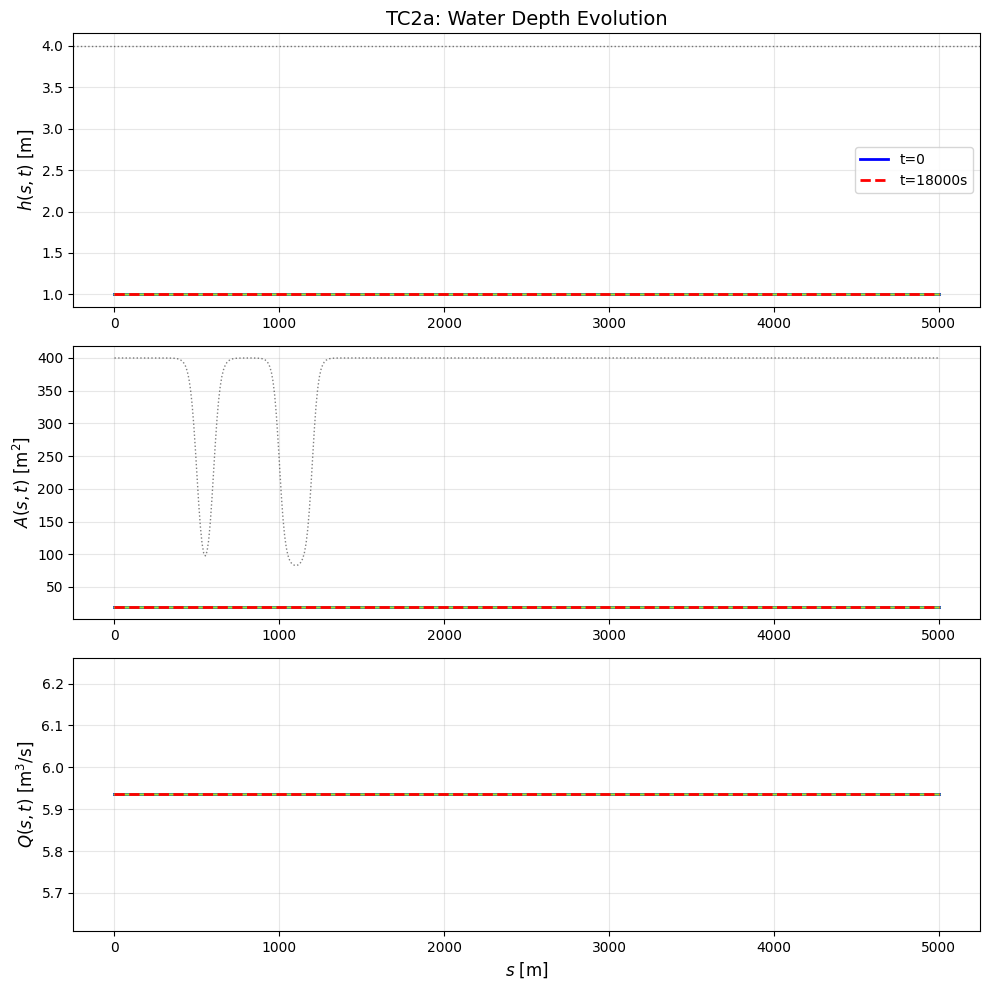

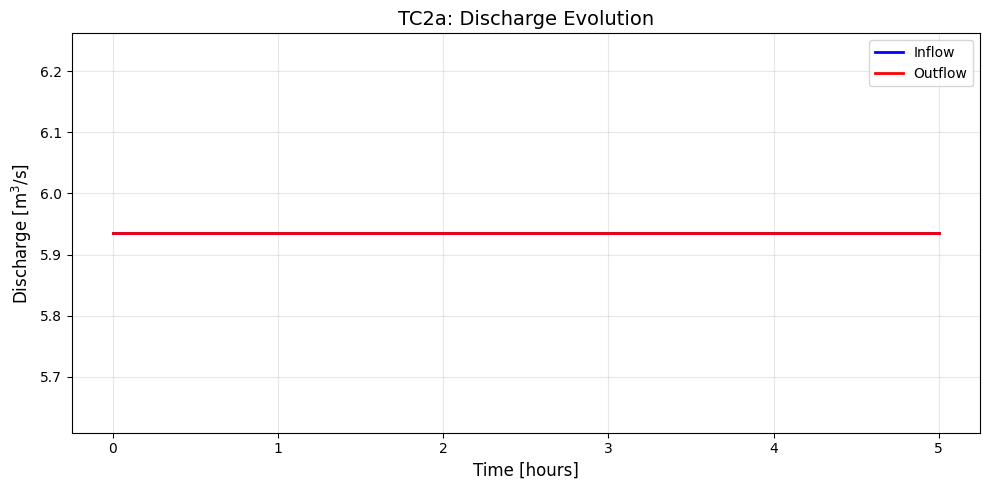

In [4]:
if __name__ == "__main__":
    # Test Case 2a: Constant inflow, compound channel
    print("\n" + "="*70)
    print("TEST CASE 2a: Constant inflow (compound channel)")
    print("="*70)
    run_simulation(test_case=2, Nx=2500, CFL=0.5, plot_results=True)

    # Convergence analysis
    print("\n" + "="*70)
    print("RUNNING CONVERGENCE STUDIES")
    print("="*70)
    convergence_analysis(test_case=2)

# Test Case 2b


TEST CASE 2b: Flood hydrograph (compound channel)

TC2b: Starting simulation
Nx = 2500, CFL = 0.5, dt = 0.3193 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m
  t = 0.3 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.1 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 2250.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 5625.3 s (nt = 17619), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 21142), Q_in = 8.15, Q_out = 5.94
  t = 7875.2 s (nt = 24666), Q_in = 104.71, Q_out = 5.94
  t = 9000.1 s (nt = 28189), Q_in = 355.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 10125.2 s (nt = 31713), Q_in = 104.62, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 11250.3 s (nt = 35237), Q_in = 8.15, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 12375.1 s (nt = 38760), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 13500.2 s (nt = 42284), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 14625.0 s (nt = 45807), Q_in = 5.94, Q_out = 195.22


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 15750.2 s (nt = 49331), Q_in = 5.94, Q_out = 124.96


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 16875.3 s (nt = 52855), Q_in = 5.94, Q_out = 83.54


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 18000.1 s (nt = 56378), Q_in = 5.94, Q_out = 58.39
Completed in 2.46 min (56378 steps, 2.62 ms/step)

TC2b Analysis:
  Initial Q_out: 5.9352 m³/s
  Final Q_out:   58.3908 m³/s
  Expected Q0:   5.9352 m³/s

Shock Speed Analysis:
  Observed speed:     0.7900 m/s
  Theoretical speed:  0.7489 m/s
  Relative error:     5.49%
  Shock at: s ≈ 2595.2 m, t ≈ 11250.3 s
  States: A_left = 392.92 m², A_right = 66.11 m²
  Fluxes: Q_left = 283.09 m³/s, Q_right = 38.35 m³/s

RUNNING CONVERGENCE STUDIES

CONVERGENCE ANALYSIS FOR TEST CASE 3

Spatial Convergence (CFL = 0.5):
------------------------------------------------------------

TC2b: Starting simulation
Nx = 500, CFL = 0.5, dt = 1.5964 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 1.6 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 705), Q_in = 5.94, Q_out = 5.94
  t = 2250.9 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 3376.3 s (nt = 2115), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 6751.1 s (nt = 4229), Q_in = 8.16, Q_out = 5.94
  t = 7876.5 s (nt = 4934), Q_in = 105.00, Q_out = 5.94
  t = 9000.4 s (nt = 5638), Q_in = 355.94, Q_out = 5.94
  t = 10125.8 s (nt = 6343), Q_in = 104.48, Q_out = 5.94
  t = 11251.3 s (nt = 7048), Q_in = 8.14, Q_out = 5.94
  t = 12375.1 s (nt = 7752), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 14626.0 s (nt = 9162), Q_in = 5.94, Q_out = 193.63
  t = 15751.5 s (nt = 9867), Q_in = 5.94, Q_out = 124.99
  t = 16875.3 s (nt = 10571), Q_in = 5.94, Q_out = 83.70
  t = 18000.7 s (nt = 11276), Q_in = 5.94, Q_out = 58.74
Completed in 0.25 min (11276 steps, 1.31 ms/step)
Nx =  500, dx = 1

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 6750.1 s (nt = 33827), Q_in = 8.15, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 7875.1 s (nt = 39465), Q_in = 104.69, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 9000.2 s (nt = 45103), Q_in = 355.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 10125.0 s (nt = 50740), Q_in = 104.65, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 11250.1 s (nt = 56378), Q_in = 8.15, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 12375.1 s (nt = 62016), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 13500.2 s (nt = 67654), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 14625.0 s (nt = 73291), Q_in = 5.94, Q_out = 195.24


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 15750.1 s (nt = 78929), Q_in = 5.94, Q_out = 124.99


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 16875.1 s (nt = 84567), Q_in = 5.94, Q_out = 83.57


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 18000.2 s (nt = 90205), Q_in = 5.94, Q_out = 58.42
Completed in 3.48 min (90205 steps, 2.31 ms/step)
CFL = 0.25, dt = 0.199547: Q_out(final) = 58.4238 m³/s

TC2b: Starting simulation
Nx = 2000, CFL = 0.5, dt = 0.3991 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 5625.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 16914), Q_in = 8.15, Q_out = 5.94
  t = 7875.3 s (nt = 19733), Q_in = 104.73, Q_out = 5.94
  t = 9000.4 s (nt = 22552), Q_in = 355.94, Q_out = 5.94
  t = 10125.0 s (nt = 25370), Q_in = 104.65, Q_out = 5.94
  t = 11250.1 s (nt = 28189), Q_in = 8.15, Q_out = 5.94
  t = 12375.1 s (nt = 31008), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 33827), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 36646), Q_in = 5.94, Q_out = 195.20
  t = 15750.3 s (nt = 39465), Q_in = 5.94, Q_out = 124.96
  t = 16875.3 s (nt = 42284), Q_in = 5.94, Q_out = 83.55
  t = 18000.3 s (nt = 45103), Q_in = 5.94, Q_out = 58.41
Completed in 1.75 min (45103 steps, 2.33 ms/step)
CFL =

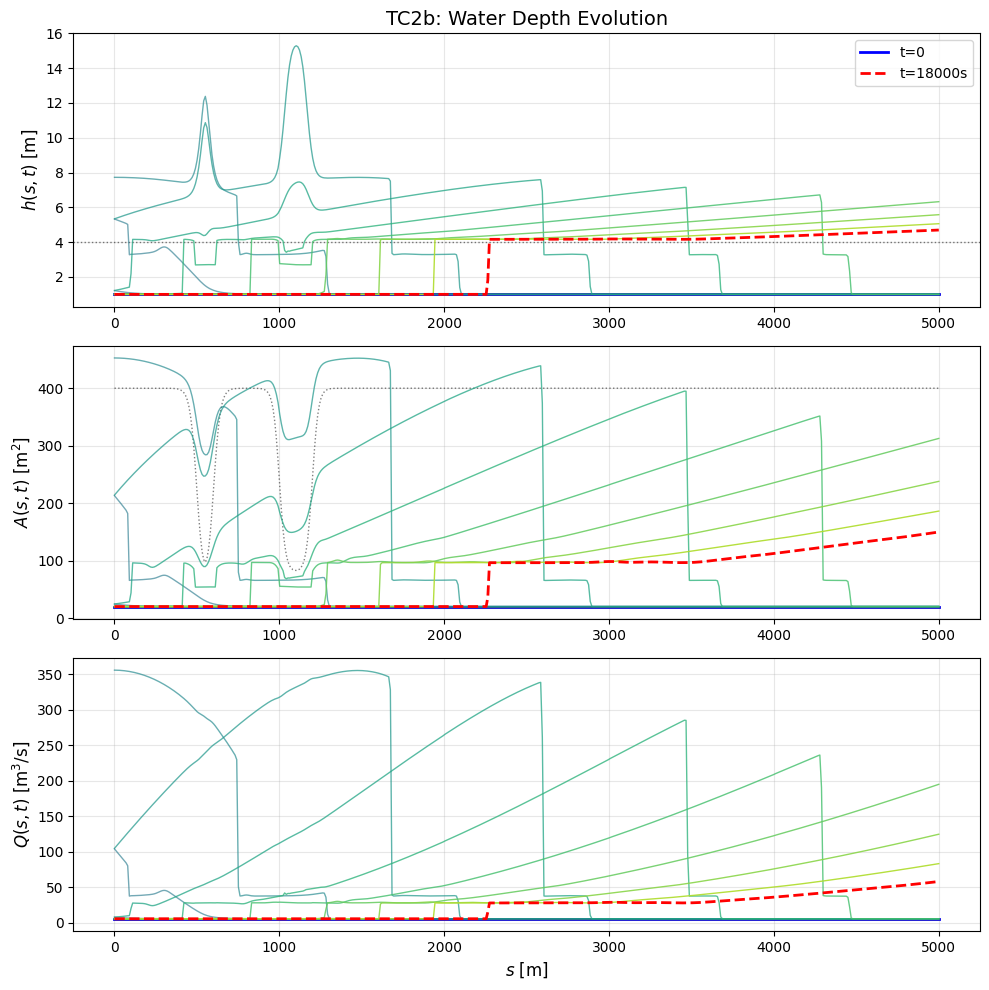

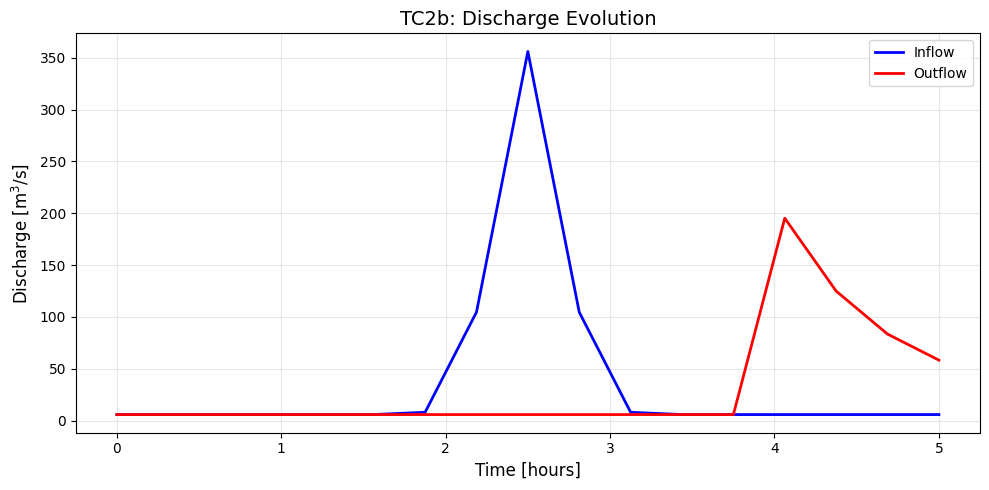

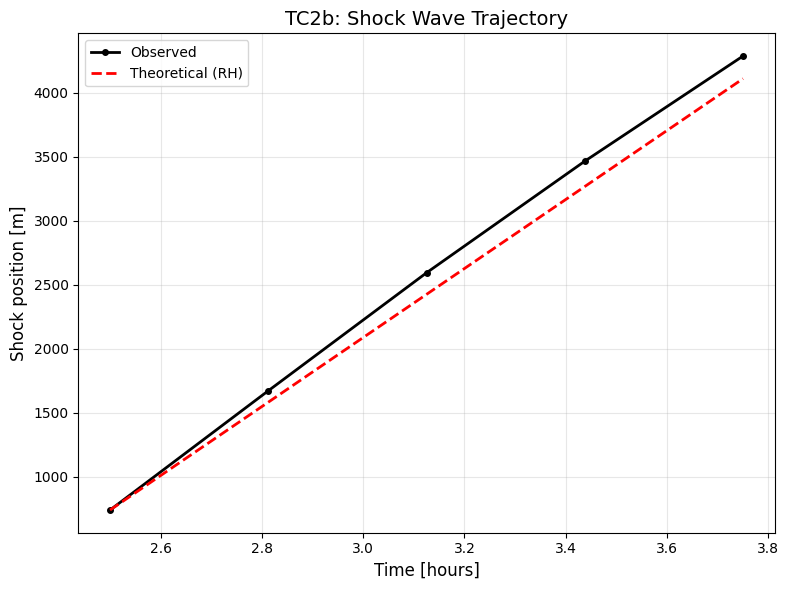

In [5]:
if __name__ == "__main__":
    # Test Case 2b: Flood hydrograph, compound channel
    print("\n" + "="*70)
    print("TEST CASE 2b: Flood hydrograph (compound channel)")
    print("="*70)
    run_simulation(test_case=3, Nx=2500, CFL=0.5, plot_results=True)

    # Convergence analysis
    print("\n" + "="*70)
    print("RUNNING CONVERGENCE STUDIES")
    print("="*70)
    convergence_analysis(test_case=3)    

# Test Case 3

In [6]:
"""
1D St-Venant Kinematic River Flow - Test Case 3
Compound channel with SLOPED flood plains (continuous profile)

Test Case 3a: Constant inflow with sloped flood plains
Test Case 3b: Flood hydrograph with sloped flood plains

The cross-section consists of:
- Central rectangular channel: width wb = 20m, depth hb = 4m
- Sloped flood plains: slope m = 0.01 (outward from channel)

This creates a CONTINUOUS variation in wetted perimeter and hydraulic radius,
eliminating the discontinuous jumps seen in TC2.
"""
from ufl import tanh as ufl_tanh, sqrt as ufl_sqrt, conditional

def width2ufl(w0, w1, w2, sa, sb, kk1, kk2, sc, sd, ss):
    """River width function with constrictions at water surface"""
    return w0 - 0.25*w1*(1+ufl_tanh(kk1*(ss-sa)))*(1+ufl_tanh(kk1*(sb-ss))) \
           - 0.25*w2*(1+ufl_tanh(kk2*(ss-sc)))*(1+ufl_tanh(kk2*(sd-ss)))

def compute_compound_geometry_sloped(A, wb, hb, m, w_top):
    """
    Compute wetted perimeter and top width for sloped flood plains
    
    Cross-section:
    - For h ≤ hb: rectangular channel of width wb
    - For h > hb: rectangular channel + two sloped sides
    
    Parameters:
    -----------
    A : cross-sectional area
    wb : channel bed width (20 m)
    hb : channel depth (4 m)
    m : flood plain slope (0.01)
    w_top : top width function w(s)
    
    Returns:
    --------
    P : wetted perimeter
    B : top width
    h : depth
    """
    
    # Critical area: when channel is exactly full
    A_critical = wb * hb
    
    # For h ≤ hb (in-channel flow)
    # A = wb * h  =>  h = A / wb
    # P = wb + 2h
    h_in = A / wb
    P_in = wb + 2 * h_in
    B_in = wb
    
    # For h > hb (overbank flow)
    # Area = A_channel + A_floodplains
    # A_channel = wb * hb
    # A_floodplains = (h - hb) * [wb + (w_top - wb)] + 2 * 0.5 * (h-hb)² / m
    # 
    # Simplified: assume w_top is the surface width
    # Area above channel: A - wb*hb = ∫[wb + 2*(h-hb)/m] d(h-hb) from 0 to h-hb
    #                                = (wb + (h-hb)/m) * (h-hb)
    # So: A - wb*hb = wb*(h-hb) + (h-hb)²/m
    # Solve for h: (h-hb)²/m + wb*(h-hb) - (A - wb*hb) = 0
    # h - hb = (-wb + sqrt(wb² + 4(A-wb*hb)/m)) / (2/m)
    
    A_excess = A - A_critical
    # Quadratic formula for depth above channel
    discriminant = wb**2 + 4 * A_excess / m
    h_above = (-wb + ufl_sqrt(discriminant)) * m / 2
    h_over = hb + h_above
    
    # Wetted perimeter for overbank flow
    # P = wb (bed) + 2*hb (channel walls) + 2*sqrt(1 + m²) * (h-hb) (sloped sides)
    slope_length = ufl_sqrt(1 + m**2)
    P_over = wb + 2*hb + 2 * slope_length * h_above
    
    # Top width for overbank flow
    # B = wb + 2*(h-hb)/m
    B_over = wb + 2 * h_above / m
    
    # Conditional selection
    h = conditional(A < A_critical, h_in, h_over)
    P = conditional(A < A_critical, P_in, P_over)
    B = conditional(A < A_critical, B_in, B_over)
    
    return P, B, h

def compute_shock_speed(times, Q_snapshots, A_snapshots, xvals, test_name):
    """Compute shock speed using Rankine-Hugoniot conditions"""
    if len(times) < 5:
        return None
    
    shock_locations = []
    shock_times_obs = []
    shock_A_left = []
    shock_A_right = []
    shock_Q_left = []
    shock_Q_right = []
    
    start_idx = max(2, len(times) // 5)
    end_idx = min(len(times) - 2, 4 * len(times) // 5)
    
    for i in range(start_idx, end_idx):
        Q_snap = Q_snapshots[i]
        A_snap = A_snapshots[i]
        
        # Find shock by maximum gradient
        dQ_ds = np.gradient(Q_snap, xvals)
        abs_grad = np.abs(dQ_ds)
        threshold = 0.3 * np.max(abs_grad)
        shock_candidates = np.where(abs_grad > threshold)[0]
        
        if len(shock_candidates) > 0:
            shock_idx = shock_candidates[0]
            
            if shock_idx > 10 and shock_idx < len(xvals) - 10:
                shock_locations.append(xvals[shock_idx])
                shock_times_obs.append(times[i])
                
                window = 5
                left_A = np.mean(A_snap[max(0, shock_idx-window):shock_idx])
                right_A = np.mean(A_snap[shock_idx+1:min(len(A_snap), shock_idx+window+1)])
                left_Q = np.mean(Q_snap[max(0, shock_idx-window):shock_idx])
                right_Q = np.mean(Q_snap[shock_idx+1:min(len(Q_snap), shock_idx+window+1)])
                
                shock_A_left.append(left_A)
                shock_A_right.append(right_A)
                shock_Q_left.append(left_Q)
                shock_Q_right.append(right_Q)
    
    if len(shock_locations) < 3:
        return None
    
    # Observed shock speed
    coeffs = np.polyfit(shock_times_obs, shock_locations, 1)
    s_shock_observed = coeffs[0]
    
    # Theoretical shock speed
    A_left_avg = np.median(shock_A_left)
    A_right_avg = np.median(shock_A_right)
    Q_left_avg = np.median(shock_Q_left)
    Q_right_avg = np.median(shock_Q_right)
    
    if abs(A_left_avg - A_right_avg) > 1e-6:
        s_shock_theoretical = (Q_left_avg - Q_right_avg) / (A_left_avg - A_right_avg)
    else:
        s_shock_theoretical = 0.0
    
    if abs(s_shock_theoretical) > 1e-6:
        error = abs(s_shock_observed - s_shock_theoretical) / abs(s_shock_theoretical) * 100
    else:
        error = 0.0
    
    mid_idx = len(shock_locations) // 2
    
    return {
        'observed_speed': s_shock_observed,
        'theoretical_speed': s_shock_theoretical,
        'error': error,
        'shock_location': shock_locations[mid_idx],
        'shock_time': shock_times_obs[mid_idx],
        'A_left': A_left_avg,
        'A_right': A_right_avg,
        'Q_left': Q_left_avg,
        'Q_right': Q_right_avg,
        'shock_trajectory': (shock_times_obs, shock_locations),
        'n_points': len(shock_locations)
    }

def run_simulation_tc3(test_case=3, Nx=2500, CFL=0.5, plot_results=True):
    """
    Run Test Case 3 with sloped flood plains
    
    Parameters:
    -----------
    test_case : int
        3 = TC3a (constant inflow)
        4 = TC3b (flood hydrograph)
    """
    
    # Physical parameters
    Lx = 5000.0
    grav = 9.81
    w0 = 100.0      # Maximum flood plain width at surface
    wb = 20.0       # Channel bed width
    hb = 4.0        # Channel depth
    m = 0.01        # Flood plain slope (horizontal/vertical = 100:1)
    H0 = 1.0        # Initial depth
    slope_bed = -0.001  # Bed slope
    sqrtmslope = np.sqrt(-slope_bed)
    Cm = 0.1
    
    # Constriction parameters
    xo = 1000.0
    xa, xb = 1500.0 - xo, 1600.0 - xo
    xc, xd = 2000.0 - xo, 2200.0 - xo
    k1, k2 = 0.024, 0.027
    w1, w2 = 90.0, 80.0
    
    # Test case parameters
    Tend = 3600.0 * 5
    Qmax = 350.0 if test_case == 4 else 0.0
    test_name = f"TC3{'b' if test_case == 4 else 'a'}"
    tmax = 0.5 * Tend
    gamfac = 0.000001
    
    # Mesh
    mesh = fd.IntervalMesh(Nx, Lx)
    x, = fd.SpatialCoordinate(mesh)
    dxx = Lx / Nx
    
    # Time step
    c00 = np.sqrt(grav * H0)
    dt = CFL * dxx / c00
    
    # Output parameters
    nmea = 16
    dtmeas = Tend / nmea
    
    # Function spaces
    DG0 = fd.FunctionSpace(mesh, "DG", 0)
    CG1 = fd.FunctionSpace(mesh, "CG", 4)
    
    # Functions
    A0 = fd.Function(DG0, name="A0")
    A1 = fd.Function(DG0, name="A1")
    wid0 = fd.Function(CG1, name="wid0")
    
    # Width function (surface width)
    wx = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, x)
    
    # Initial conditions: start with in-channel flow
    A0.interpolate(H0 * wb)
    wid0.interpolate(wx)
    
    # Test and trial functions
    A0_trial = fd.TrialFunction(DG0)
    A0_test = fd.TestFunction(DG0)
    
    # Mass matrix
    a_massA0 = A0_test * A0_trial * fd.dx
    
    # Facet normal
    n = fd.FacetNormal(mesh)
    
    # Constants
    wb_const = fd.Constant(wb)
    hb_const = fd.Constant(hb)
    m_const = fd.Constant(m)
    
    # Compute geometry for general A
    widL = wx
    P, B, h = compute_compound_geometry_sloped(A0, wb_const, hb_const, m_const, widL)
    
    # Flux function: F = sqrt(-slope) * A^(5/3) / P^(2/3) / Cm
    FA0 = sqrtmslope * A0**(5/3) / P**(2/3) / Cm
    
    # For interior fluxes
    A0avg = 0.5 * (A0('+') + A0('-'))
    P_minus, B_minus, h_minus = compute_compound_geometry_sloped(A0('-'), wb_const, hb_const, m_const, widL)
    P_plus, B_plus, h_plus = compute_compound_geometry_sloped(A0('+'), wb_const, hb_const, m_const, widL)
    
    FA0fluxmin = sqrtmslope * A0('-')**(5/3) / P_minus**(2/3) / Cm
    FA0fluxplu = sqrtmslope * A0('+')**(5/3) / P_plus**(2/3) / Cm
    
    # Characteristic speed: dF/dA (approximate for conditional geometry)
    # For smooth geometry: dF/dA ≈ (5/3)*F/A - (2/3)*F/P * dP/dA
    # Simplified: use upwind based on F values
    dFA0dA0 = (FA0fluxplu - FA0fluxmin) / (A0('+') - A0('-') + 1e-10)
    
    # Boundary conditions
    widL0 = width2ufl(w0, w1, w2, xa, xb, k1, k2, xc, xd, 0.0)
    A0left0 = H0 * wb
    P0, B0, h0 = compute_compound_geometry_sloped(fd.Constant(A0left0), wb_const, hb_const, m_const, fd.Constant(widL0))
    
    # Compute FA0left0 using Python
    P0_val = wb + 2 * H0  # In-channel initially
    FA0left0 = sqrtmslope * A0left0**(5/3) / P0_val**(2/3) / Cm
    
    FA0left = fd.Constant(FA0left0)
    
    # Boundary flux (simplified - assume same upwinding)
    P_bnd, B_bnd, h_bnd = compute_compound_geometry_sloped(A0, wb_const, hb_const, m_const, widL)
    FA0_bnd = sqrtmslope * A0**(5/3) / P_bnd**(2/3) / Cm
    
    FA0fluxbcl = FA0left  # Inflow
    FA0fluxbcr = FA0_bnd  # Outflow
    
    # Upwind flux (use simple upwinding based on normal)
    FA0flux = conditional(n[0]('+') > 0, FA0fluxmin, FA0fluxplu)
    
    # Variational form
    A0rhs = A0_test * A0 * fd.dx - dt * FA0flux * n[0]('+') * (A0_test('+') - A0_test('-')) * fd.dS
    A0rhs = A0rhs - dt * FA0fluxbcl * n[0] * A0_test * fd.ds(1) - dt * FA0fluxbcr * n[0] * A0_test * fd.ds(2)
    
    # Solver
    A0_problem = fd.LinearVariationalProblem(a_massA0, A0rhs, A1)
    solver = fd.LinearVariationalSolver(A0_problem)
    
    # Storage
    times = []
    Q_inflow = []
    Q_outflow = []
    snapshot_times = []
    snapshot_h = []
    snapshot_A = []
    snapshot_Q = []
    snapshot_B = []
    
    # Sample points
    nx_plot = min(500, Nx)
    xvals = np.linspace(0.0, Lx, nx_plot)
    
    if plot_results:
        fig, axes = plt.subplots(4, 1, figsize=(10, 12))
        tsize = 12
        axes[0].set_ylabel(r'$h(s,t)$ [m]', fontsize=tsize)
        axes[0].grid(True, alpha=0.3)
        axes[1].set_ylabel(r'$B(s,t)$ [m]', fontsize=tsize)
        axes[1].grid(True, alpha=0.3)
        axes[2].set_ylabel(r'$A(s,t)$ [m$^2$]', fontsize=tsize)
        axes[2].grid(True, alpha=0.3)
        axes[3].set_xlabel(r'$s$ [m]', fontsize=tsize)
        axes[3].set_ylabel(r'$Q(s,t)$ [m$^3$/s]', fontsize=tsize)
        axes[3].grid(True, alpha=0.3)
        
        # Mark channel depth
        axes[0].axhline(hb, color='k', linestyle=':', linewidth=1, alpha=0.5, label='Bank height')
        axes[0].legend(loc='upper right')
    
    # Time integration
    print(f"\n{test_name}: Sloped Flood Plains")
    print(f"Nx = {Nx}, CFL = {CFL}, dt = {dt:.4f} s, Tend = {Tend:.0f} s")
    print(f"Channel: wb = {wb} m, hb = {hb} m, Flood plain slope: m = {m}")
    print(f"Max surface width: w0 = {w0} m")
    
    t = 0.0
    nt = 0
    tmease = 0.0
    smallfac = 1e-10
    tic = time.time()
    
    # Pre-create functions for output
    h_out = fd.Function(DG0)
    B_out = fd.Function(DG0)
    FA0_out = fd.Function(DG0)
    
    while t < Tend:
        t += dt
        nt += 1
        
        # Update inflow
        if Qmax > 0:
            Q_in = FA0left0 + Qmax * np.exp(-gamfac * (t - tmax)**2)
            FA0left.assign(Q_in)
        else:
            Q_in = FA0left0
        
        # Solve
        solver.solve()
        A0.assign(A1)
        
        # Diagnostics at output times
        if t > tmease - smallfac or nt == 1:
            # Compute outputs
            P_out, B_temp, h_temp = compute_compound_geometry_sloped(A0, wb_const, hb_const, m_const, widL)
            h_out.interpolate(h_temp)
            B_out.interpolate(B_temp)
            FA0_out.interpolate(sqrtmslope * A0**(5/3) / P_out**(2/3) / Cm)
            
            Q_out = FA0_out.dat.data[-1]
            times.append(t)
            Q_inflow.append(Q_in)
            Q_outflow.append(Q_out)
        
        # Store snapshots
        if t > tmease - smallfac:
            tmease += dtmeas
            
            A_vals = np.array([A0.at(x) for x in xvals])
            h_vals = np.array([h_out.at(x) for x in xvals])
            B_vals = np.array([B_out.at(x) for x in xvals])
            Q_vals = np.array([FA0_out.at(x) for x in xvals])
            
            snapshot_times.append(t)
            snapshot_h.append(h_vals)
            snapshot_A.append(A_vals)
            snapshot_Q.append(Q_vals)
            snapshot_B.append(B_vals)
            
            print(f"  t = {t:.1f} s (nt = {nt}), Q_in = {Q_in:.2f}, Q_out = {Q_out:.2f}")
    
    toc = time.time() - tic
    print(f"Completed in {toc/60:.2f} min ({nt} steps, {toc/nt*1000:.2f} ms/step)")
    
    # Plotting
    if plot_results:
        n_snapshots = len(snapshot_times)
        for i, t_snap in enumerate(snapshot_times):
            alpha = np.clip(0.4 + 0.6 * (i / n_snapshots), 0.0, 1.0)
            color = plt.cm.viridis(i / n_snapshots)
            
            if i == 0:
                axes[0].plot(xvals, snapshot_h[i], 'b-', linewidth=2, label='t=0')
                axes[1].plot(xvals, snapshot_B[i], 'b-', linewidth=2)
                axes[2].plot(xvals, snapshot_A[i], 'b-', linewidth=2)
                axes[3].plot(xvals, snapshot_Q[i], 'b-', linewidth=2)
            elif i == n_snapshots - 1:
                axes[0].plot(xvals, snapshot_h[i], 'r--', linewidth=2, label=f't={Tend:.0f}s')
                axes[1].plot(xvals, snapshot_B[i], 'r--', linewidth=2)
                axes[2].plot(xvals, snapshot_A[i], 'r--', linewidth=2)
                axes[3].plot(xvals, snapshot_Q[i], 'r--', linewidth=2)
            else:
                axes[0].plot(xvals, snapshot_h[i], color=color, alpha=alpha, linewidth=1)
                axes[1].plot(xvals, snapshot_B[i], color=color, alpha=alpha, linewidth=1)
                axes[2].plot(xvals, snapshot_A[i], color=color, alpha=alpha, linewidth=1)
                axes[3].plot(xvals, snapshot_Q[i], color=color, alpha=alpha, linewidth=1)
        
        axes[0].legend()
        axes[0].set_title(f'{test_name}: Sloped Flood Plains - Continuous Profile', fontsize=14)
        fig.tight_layout()
        fig.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_profiles.png", dpi=150)
        
        # Discharge time series
        fig2, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.array(times)/3600, Q_inflow, 'b-', linewidth=2, label='Inflow')
        ax.plot(np.array(times)/3600, Q_outflow, 'r-', linewidth=2, label='Outflow')
        ax.set_xlabel('Time [hours]', fontsize=12)
        ax.set_ylabel('Discharge [m$^3$/s]', fontsize=12)
        ax.set_title(f'{test_name}: Discharge Evolution', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
        fig2.tight_layout()
        fig2.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_discharge.png", dpi=150)
        
        # Cross-section evolution plot
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        for i in [0, n_snapshots//4, n_snapshots//2, 3*n_snapshots//4, n_snapshots-1]:
            t_label = f't={snapshot_times[i]:.0f}s'
            color = plt.cm.viridis(i / n_snapshots)
            ax3.plot(xvals, snapshot_B[i], color=color, linewidth=2, label=t_label)
        
        ax3.axhline(wb, color='k', linestyle=':', linewidth=1, alpha=0.5, label='Channel width')
        ax3.set_xlabel('s [m]', fontsize=12)
        ax3.set_ylabel('Top width B(s,t) [m]', fontsize=12)
        ax3.set_title(f'{test_name}: Surface Width Evolution', fontsize=14)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        fig3.tight_layout()
        fig3.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_topwidth.png", dpi=150)
        
        # Analysis
        print(f"\n{test_name} Analysis:")
        print(f"  Initial Q_out: {Q_outflow[0]:.4f} m³/s")
        print(f"  Final Q_out:   {Q_outflow[-1]:.4f} m³/s")
        print(f"  Expected Q0:   {FA0left0:.4f} m³/s")
        
        if Qmax == 0:
            error = abs(Q_outflow[-1] - FA0left0) / FA0left0 * 100
            print(f"  Steady-state error: {error:.2f}%")
        else:
            # Shock analysis
            shock_analysis = compute_shock_speed(snapshot_times, snapshot_Q, snapshot_A, 
                                                xvals, test_name)
            if shock_analysis and shock_analysis['n_points'] >= 3:
                print(f"\nShock Speed Analysis:")
                print(f"  Observed speed:     {shock_analysis['observed_speed']:.4f} m/s")
                print(f"  Theoretical speed:  {shock_analysis['theoretical_speed']:.4f} m/s")
                print(f"  Relative error:     {shock_analysis['error']:.2f}%")
                print(f"  Shock at: s ≈ {shock_analysis['shock_location']:.1f} m, t ≈ {shock_analysis['shock_time']:.1f} s")
                
                # Plot shock trajectory
                fig4, ax4 = plt.subplots(figsize=(8, 6))
                shock_t, shock_s = shock_analysis['shock_trajectory']
                ax4.plot(np.array(shock_t)/3600, shock_s, 'ko-', linewidth=2, markersize=4, label='Observed')
                
                t_theory = np.array(shock_t)
                s_theory = shock_s[0] + shock_analysis['theoretical_speed'] * (t_theory - shock_t[0])
                ax4.plot(t_theory/3600, s_theory, 'r--', linewidth=2, label='Theoretical (RH)')
                
                ax4.set_xlabel('Time [hours]', fontsize=12)
                ax4.set_ylabel('Shock position [m]', fontsize=12)
                ax4.set_title(f'{test_name}: Shock Wave Trajectory', fontsize=14)
                ax4.legend()
                ax4.grid(True, alpha=0.3)
                fig4.tight_layout()
                fig4.savefig(f"{test_name}_Nx{Nx}_CFL{CFL:.2f}_shock.png", dpi=150)
        
        print(f"\nKey Observation:")
        print(f"  With sloped flood plains (m={m}), the geometry changes CONTINUOUSLY.")
        print(f"  This eliminates the discontinuous jumps seen in TC2.")
        print(f"  The wetted perimeter P(A) and hydraulic radius R(A) are now smooth functions.")
    
    return {
        'times': np.array(times),
        'Q_inflow': np.array(Q_inflow),
        'Q_outflow': np.array(Q_outflow),
        'Nx': Nx, 'dt': dt, 'CFL': CFL,
        'xvals': xvals,
        'snapshots': (snapshot_times, snapshot_h, snapshot_A, snapshot_Q, snapshot_B)
    }

def convergence_analysis_tc3(test_case=3):
    """Convergence analysis for TC3"""
    test_name = f"TC3{'b' if test_case == 4 else 'a'}"
    print(f"\n{'='*70}")
    print(f"CONVERGENCE ANALYSIS: {test_name}")
    print(f"{'='*70}")
    
    # Spatial convergence
    Nx_values = [500, 1000, 2000, 4000]
    CFL_fixed = 0.5
    
    print(f"\nSpatial Convergence (CFL = {CFL_fixed}):")
    print("-" * 70)
    
    Q_final_spatial = []
    for Nx in Nx_values:
        result = run_simulation_tc3(test_case=test_case, Nx=Nx, CFL=CFL_fixed, plot_results=False)
        Q_final_spatial.append(result['Q_outflow'][-1])
        print(f"Nx = {Nx:4d}, dx = {5000.0/Nx:.4f} m: Q_out = {Q_final_spatial[-1]:.4f} m³/s")
    
    # Estimate convergence rate
    if len(Q_final_spatial) >= 3:
        print("\nConvergence rates (consecutive resolutions):")
        for i in range(len(Q_final_spatial) - 1):
            if i < len(Q_final_spatial) - 2:
                error_i = abs(Q_final_spatial[i] - Q_final_spatial[-1])
                error_ip1 = abs(Q_final_spatial[i+1] - Q_final_spatial[-1])
                if error_ip1 > 1e-10:
                    ratio = error_i / error_ip1
                    rate = np.log(ratio) / np.log(2)
                    print(f"  Nx {Nx_values[i]} -> {Nx_values[i+1]}: rate ≈ {rate:.2f}")
    
    # Temporal convergence
    CFL_values = [0.25, 0.5, 1.0]
    Nx_fixed = 2000
    
    print(f"\nTemporal Convergence (Nx = {Nx_fixed}):")
    print("-" * 70)
    
    Q_final_temporal = []
    for CFL in CFL_values:
        result = run_simulation_tc3(test_case=test_case, Nx=Nx_fixed, CFL=CFL, plot_results=False)
        Q_final_temporal.append(result['Q_outflow'][-1])
        print(f"CFL = {CFL:.2f}, dt = {result['dt']:.6f} s: Q_out = {Q_final_temporal[-1]:.4f} m³/s")
    
    print(f"\n{'='*70}")


TEST CASE 3a: Constant inflow - Sloped flood plains
Cross-section: Rectangular channel (20m × 4m) + sloped sides (m=0.01)

TC3a: Sloped Flood Plains
Nx = 2500, CFL = 0.5, dt = 0.3193 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain slope: m = 0.01
Max surface width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.3 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.1 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 2250.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 5625.3 s (nt = 17619), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 21142), Q_in = 5.94, Q_out = 5.94
  t = 7875.2 s (nt = 24666), Q_in = 5.94, Q_out = 5.94
  t = 9000.1 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 10125.2 s (nt = 31713), Q_in = 5.94, Q_out = 5.94
  t = 11250.3 s (nt = 35237), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 38760), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 42284), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 45807), Q_in = 5.94, Q_out = 5.94
  t = 15750.2 s (nt = 49331), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 52855), Q_in = 5.94, Q_out = 5.94
  t = 18000.1 s (nt = 56378), Q_in = 5.94, Q_out = 5.94
Completed in 2.44 min (56378 steps, 2.60 ms/step)

TC3a Analysis:


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.3 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.1 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 2250.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 5625.3 s (nt = 17619), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 21142), Q_in = 8.15, Q_out = 5.94
  t = 7875.2 s (nt = 24666), Q_in = 104.71, Q_out = 5.94
  t = 9000.1 s (nt = 28189), Q_in = 355.94, Q_out = 5.94
  t = 10125.2 s (nt = 31713), Q_in = 104.62, Q_out = 5.94
  t = 11250.3 s (nt = 35237), Q_in = 8.15, Q_out = 5.94
  t = 12375.1 s (nt = 38760), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 42284), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 45807), Q_in = 5.94, Q_out = 5.94
  t = 15750.2 s (nt = 49331), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 52855), Q_in = 5.94, Q_out = 5.94
  t = 18000.1 s (nt = 56378), Q_in = 5.94, Q_out = 5.94
Completed in 2.40 min (56378 steps, 2.55 ms/step)

TC3b Anal

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 1.6 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 705), Q_in = 5.94, Q_out = 5.94
  t = 2250.9 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 3376.3 s (nt = 2115), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 3524), Q_in = 5.94, Q_out = 5.94
  t = 6751.1 s (nt = 4229), Q_in = 5.94, Q_out = 5.94
  t = 7876.5 s (nt = 4934), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 10125.8 s (nt = 6343), Q_in = 5.94, Q_out = 5.94
  t = 11251.3 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 7752), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 14626.0 s (nt = 9162), Q_in = 5.94, Q_out = 5.94
  t = 15751.5 s (nt = 9867), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 10571), Q_in = 5.94, Q_out = 5.94
  t = 18000.7 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
Completed in 0.27 min (11276 steps, 1.42 ms/step)
Nx =  500, dx = 10.0000 m: Q_

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.8 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 3375.5 s (nt = 4229), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 7875.7 s (nt = 9867), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 12685), Q_in = 5.94, Q_out = 5.94
  t = 11250.5 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 15504), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 18323), Q_in = 5.94, Q_out = 5.94
  t = 15750.7 s (nt = 19733), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 21142), Q_in = 5.94, Q_out = 5.94
  t = 18000.7 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
Completed in 0.61 min (22552 steps, 1.63 ms/step)
Nx = 1000, dx = 5.000

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.4 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 5625.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 7875.3 s (nt = 19733), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 25370), Q_in = 5.94, Q_out = 5.94
  t = 11250.1 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 31008), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 33827), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 36646), Q_in = 5.94, Q_out = 5.94
  t = 15750.3 s (nt = 39465), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 42284), Q_in = 5.94, Q_out = 5.94
  t = 18000.3 s (nt = 45103), Q_in = 5.94, Q_out = 5.94
Completed in 1.68 min (45103 steps, 2.24 ms/step)
Nx = 2000, dx = 2

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.2 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 5625.0 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 33827), Q_in = 5.94, Q_out = 5.94
  t = 7875.1 s (nt = 39465), Q_in = 5.94, Q_out = 5.94
  t = 9000.2 s (nt = 45103), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 50740), Q_in = 5.94, Q_out = 5.94
  t = 11250.1 s (nt = 56378), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 62016), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 67654), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 73291), Q_in = 5.94, Q_out = 5.94
  t = 15750.1 s (nt = 78929), Q_in = 5.94, Q_out = 5.94
  t = 16875.1 s (nt = 84567), Q_in = 5.94, Q_out = 5.94
  t = 18000.2 s (nt = 90205), Q_in = 5.94, Q_out = 5.94
Completed in 5.39 min (90205 steps, 3.58 ms/step)
Nx = 4000, dx =

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 2250.1 s (nt = 5638), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 3375.1 s (nt = 8457), Q_in = 5.94, Q_out = 5.94


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 4500.2 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 5625.2 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 7875.3 s (nt = 19733), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 25370), Q_in = 5.94, Q_out = 5.94
  t = 11250.1 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 31008), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 33827), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 36646), Q_in = 5.94, Q_out = 5.94
  t = 15750.3 s (nt = 39465), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 42284), Q_in = 5.94, Q_out = 5.94
  t = 18000.3 s (nt = 45103), Q_in = 5.94, Q_out = 5.94
Completed in 1.63 min (45103 steps, 2.17 ms/step)
CFL = 0.50, dt = 0.399094 s: Q_out = 5.9352 m³/s

TC3a: Sloped Flood Plains
Nx = 2000, CFL = 1.0, dt = 0.7982 s, Tend = 18000 s
Channel: wb = 20.0 m, hb = 4.0 m, Flood plain slope: m = 0.01
Max surface width: w0 = 100.0 m


/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.8 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.4 s (nt = 1410), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 2819), Q_in = 5.94, Q_out = 5.94
  t = 3375.5 s (nt = 4229), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 5625.6 s (nt = 7048), Q_in = 5.94, Q_out = 5.94
  t = 6750.3 s (nt = 8457), Q_in = 5.94, Q_out = 5.94
  t = 7875.7 s (nt = 9867), Q_in = 5.94, Q_out = 5.94
  t = 9000.4 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 10125.0 s (nt = 12685), Q_in = 5.94, Q_out = 5.94
  t = 11250.5 s (nt = 14095), Q_in = 5.94, Q_out = 5.94
  t = 12375.1 s (nt = 15504), Q_in = 5.94, Q_out = 5.94
  t = 13500.6 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 14625.2 s (nt = 18323), Q_in = 5.94, Q_out = 5.94
  t = 15750.7 s (nt = 19733), Q_in = 5.94, Q_out = 5.94
  t = 16875.3 s (nt = 21142), Q_in = 5.94, Q_out = 5.94
  t = 18000.7 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
Completed in 0.85 min (22552 steps, 2.26 ms/step)
CFL = 1.00, dt = 0.79

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.2 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 5625.0 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 33827), Q_in = 8.15, Q_out = 5.94
  t = 7875.1 s (nt = 39465), Q_in = 104.69, Q_out = 5.94
  t = 9000.2 s (nt = 45103), Q_in = 355.94, Q_out = 5.94
  t = 10125.0 s (nt = 50740), Q_in = 104.65, Q_out = 5.94
  t = 11250.1 s (nt = 56378), Q_in = 8.15, Q_out = 5.94
  t = 12375.1 s (nt = 62016), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 67654), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 73291), Q_in = 5.94, Q_out = 5.94
  t = 15750.1 s (nt = 78929), Q_in = 5.94, Q_out = 5.94
  t = 16875.1 s (nt = 84567), Q_in = 5.94, Q_out = 5.94
  t = 18000.2 s (nt = 90205), Q_in = 5.94, Q_out = 5.94
Completed in 5.48 min (90205 steps, 3.65 ms/step)
Nx = 4000

/opt/firedrake/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


  t = 0.2 s (nt = 1), Q_in = 5.94, Q_out = 5.94
  t = 1125.0 s (nt = 5638), Q_in = 5.94, Q_out = 5.94
  t = 2250.1 s (nt = 11276), Q_in = 5.94, Q_out = 5.94
  t = 3375.1 s (nt = 16914), Q_in = 5.94, Q_out = 5.94
  t = 4500.2 s (nt = 22552), Q_in = 5.94, Q_out = 5.94
  t = 5625.0 s (nt = 28189), Q_in = 5.94, Q_out = 5.94
  t = 6750.1 s (nt = 33827), Q_in = 8.15, Q_out = 5.94
  t = 7875.1 s (nt = 39465), Q_in = 104.69, Q_out = 5.94
  t = 9000.2 s (nt = 45103), Q_in = 355.94, Q_out = 5.94
  t = 10125.0 s (nt = 50740), Q_in = 104.65, Q_out = 5.94
  t = 11250.1 s (nt = 56378), Q_in = 8.15, Q_out = 5.94
  t = 12375.1 s (nt = 62016), Q_in = 5.94, Q_out = 5.94
  t = 13500.2 s (nt = 67654), Q_in = 5.94, Q_out = 5.94
  t = 14625.0 s (nt = 73291), Q_in = 5.94, Q_out = 5.94
  t = 15750.1 s (nt = 78929), Q_in = 5.94, Q_out = 5.94
  t = 16875.1 s (nt = 84567), Q_in = 5.94, Q_out = 5.94
  t = 18000.2 s (nt = 90205), Q_in = 5.94, Q_out = 5.94
Completed in 3.33 min (90205 steps, 2.22 ms/step)
CFL = 0.2

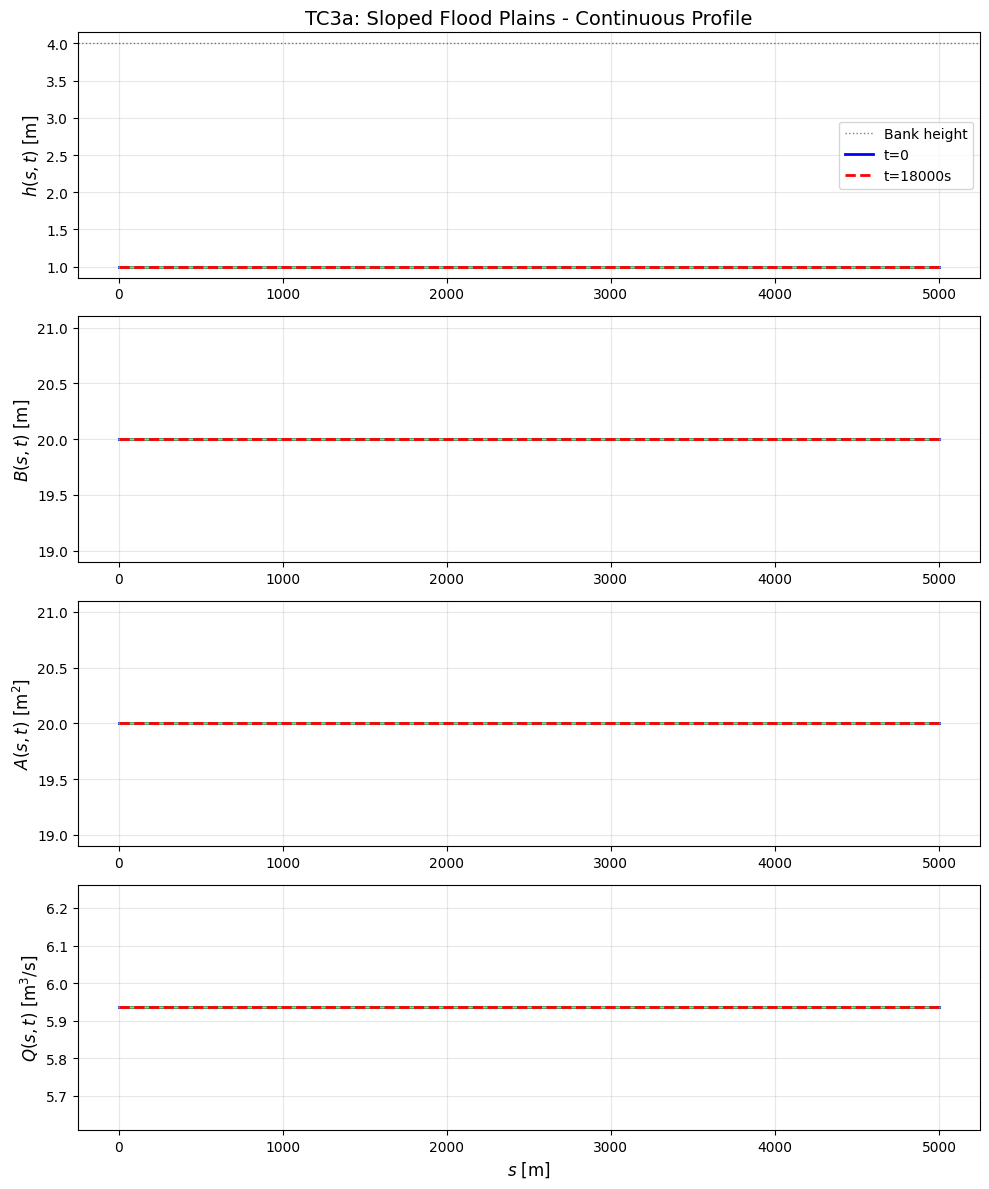

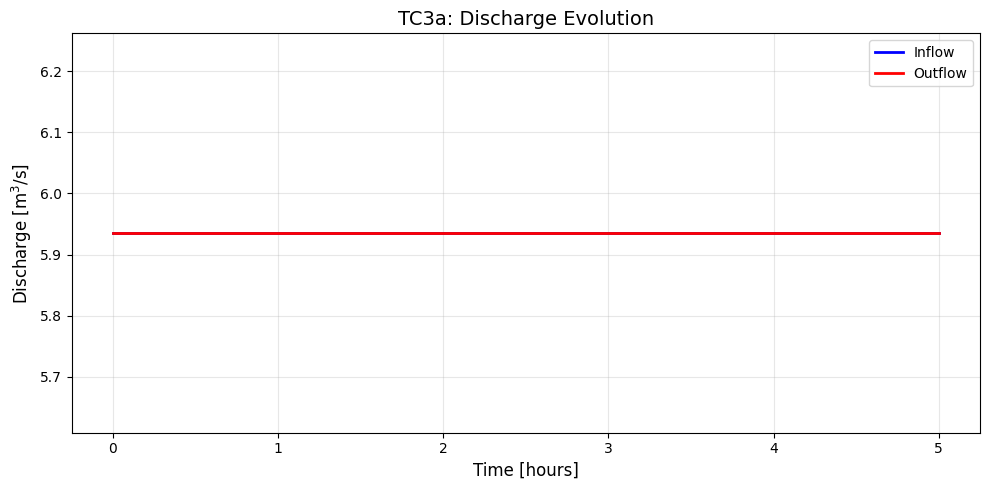

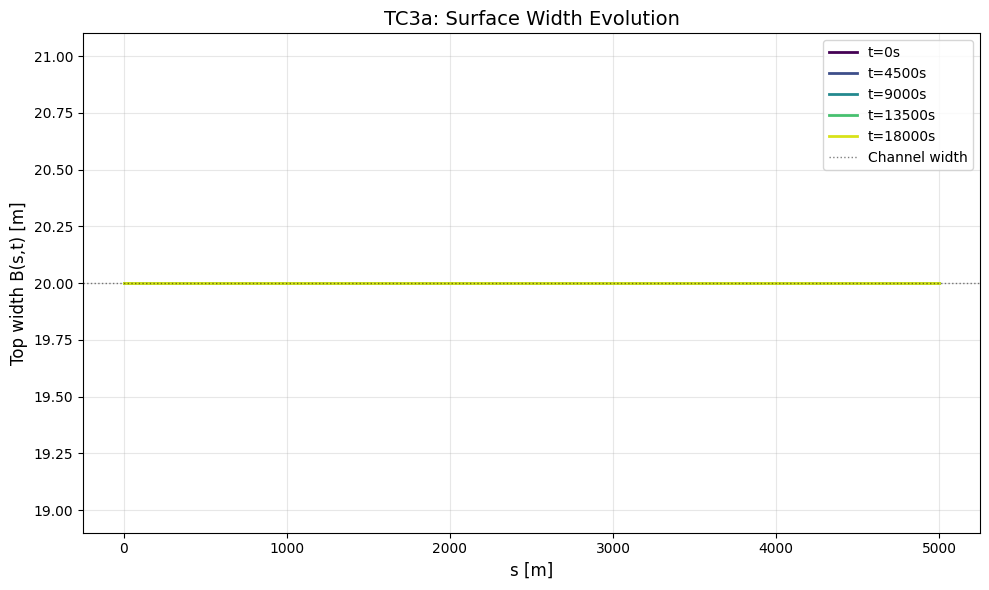

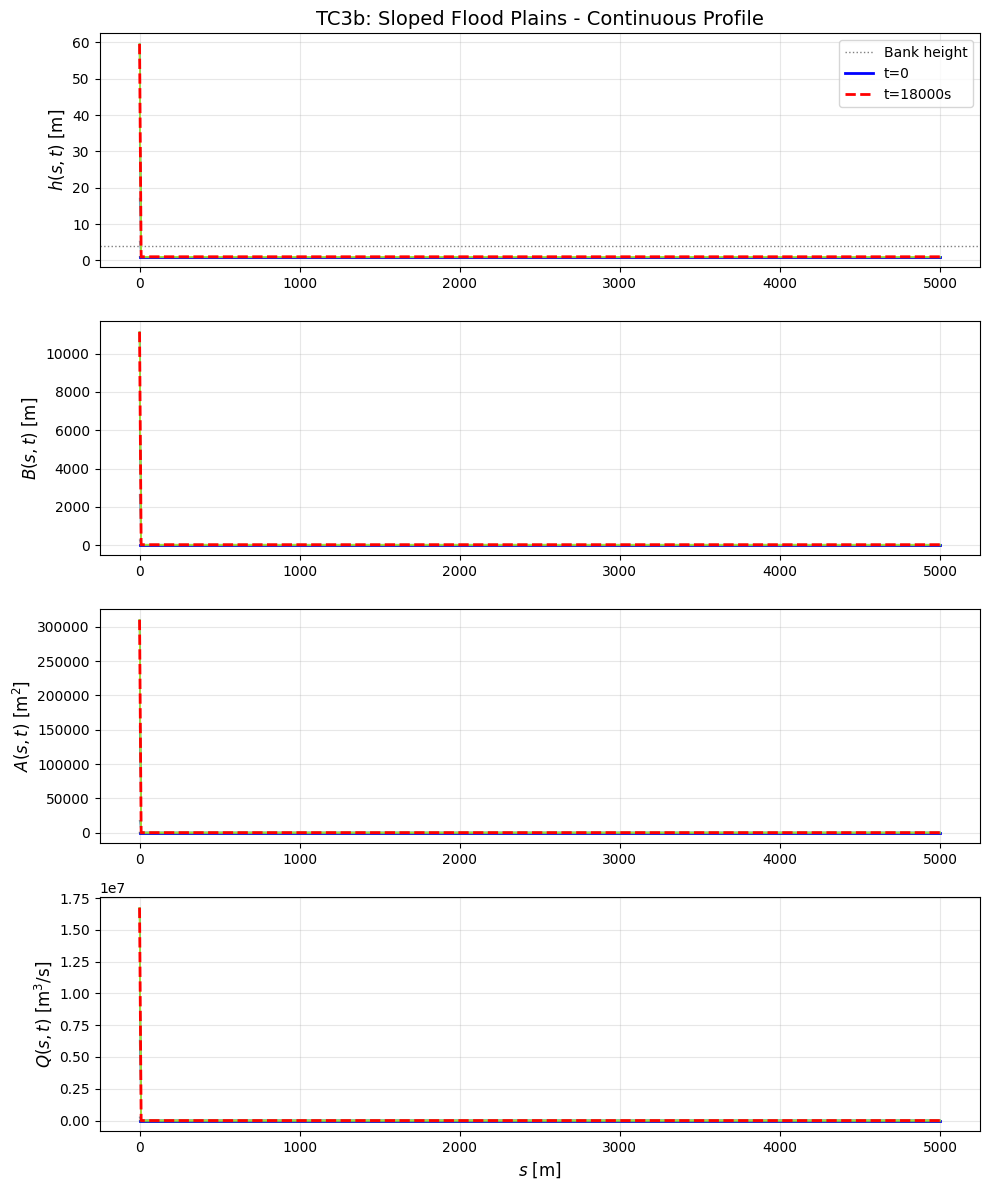

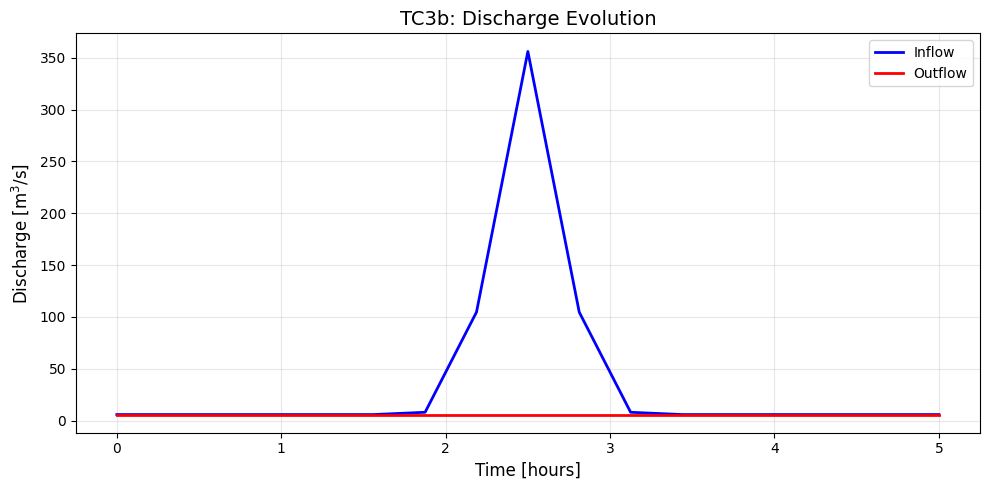

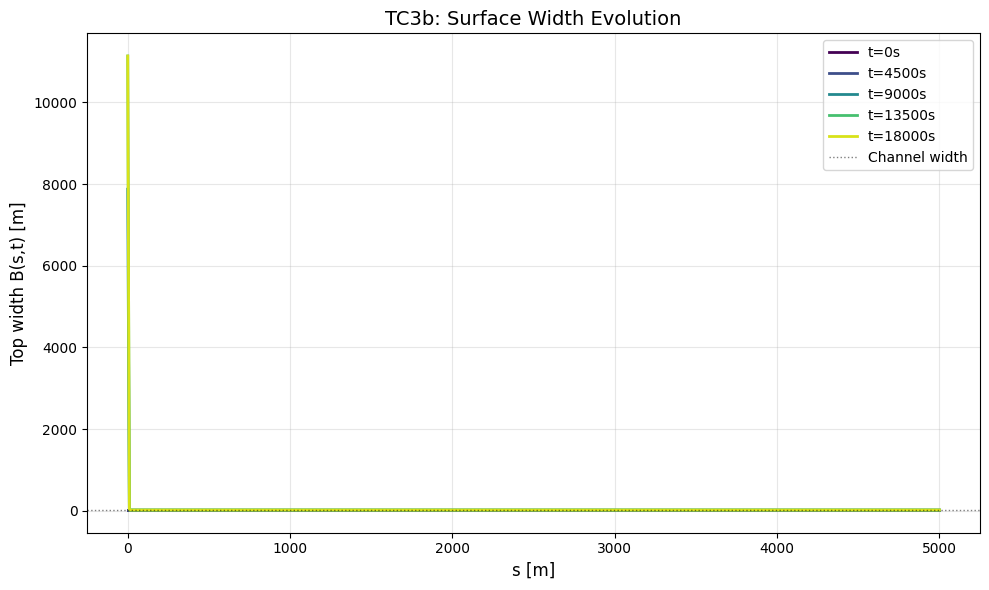


TEST CASE 3 COMPLETED - KEY FINDINGS

Comparison: TC2 (Rectangular) vs TC3 (Sloped)
----------------------------------------------------------------------

TC2 (Rectangular flood plains):
  • Discontinuous geometry at A = wb*hb (80 m²)
  • Wetted perimeter P(A) has discontinuous derivative
  • Creates artificial small shocks at transition
  • dF/dA is discontinuous

TC3 (Sloped flood plains, m=0.01):
  • CONTINUOUS geometry for all A
  • Smooth transition from channel to overbank flow
  • P(A) = wb + 2*hb + 2*sqrt(1+m²)*(h-hb) for h > hb
  • No artificial jumps - only the main flood shock
  • More physically realistic

Geometric formulas for TC3:
  In-channel (h ≤ 4m):
    A = wb*h = 20*h
    P = wb + 2*h = 20 + 2*h
  Overbank (h > 4m):
    A = 80 + 20*(h-4) + (h-4)²/m
    P = 20 + 8 + 2*sqrt(1+m²)*(h-4)
    B = 20 + 2*(h-4)/m

Numerical properties:
  • Scheme: First-order FV upwind
  • Spatial accuracy: O(Δx)
  • Temporal accuracy: O(Δt)
  • Stability: CFL ≤ 1

Physical insights:
  •

In [7]:
if __name__ == "__main__":
    # Test Case 3a: Constant inflow with sloped flood plains
    print("\n" + "="*70)
    print("TEST CASE 3a: Constant inflow - Sloped flood plains")
    print("="*70)
    print("Cross-section: Rectangular channel (20m × 4m) + sloped sides (m=0.01)")
    run_simulation_tc3(test_case=3, Nx=2500, CFL=0.5, plot_results=True)
    
    # Test Case 3b: Flood hydrograph with sloped flood plains
    print("\n" + "="*70)
    print("TEST CASE 3b: Flood hydrograph - Sloped flood plains")
    print("="*70)
    print("Cross-section: Rectangular channel (20m × 4m) + sloped sides (m=0.01)")
    run_simulation_tc3(test_case=4, Nx=2500, CFL=0.5, plot_results=True)
    
    # Convergence analysis (uncomment to run)
    print("\n" + "="*70)
    print("RUNNING CONVERGENCE STUDIES")
    print("="*70)
    convergence_analysis_tc3(test_case=3)
    convergence_analysis_tc3(test_case=4)
    
    plt.show()
    
    print("\n" + "="*70)
    print("TEST CASE 3 COMPLETED - KEY FINDINGS")
    print("="*70)
    print("\nComparison: TC2 (Rectangular) vs TC3 (Sloped)")
    print("-" * 70)
    print("\nTC2 (Rectangular flood plains):")
    print("  • Discontinuous geometry at A = wb*hb (80 m²)")
    print("  • Wetted perimeter P(A) has discontinuous derivative")
    print("  • Creates artificial small shocks at transition")
    print("  • dF/dA is discontinuous")
    print("\nTC3 (Sloped flood plains, m=0.01):")
    print("  • CONTINUOUS geometry for all A")
    print("  • Smooth transition from channel to overbank flow")
    print("  • P(A) = wb + 2*hb + 2*sqrt(1+m²)*(h-hb) for h > hb")
    print("  • No artificial jumps - only the main flood shock")
    print("  • More physically realistic")
    print("\nGeometric formulas for TC3:")
    print("  In-channel (h ≤ 4m):")
    print("    A = wb*h = 20*h")
    print("    P = wb + 2*h = 20 + 2*h")
    print("  Overbank (h > 4m):")
    print("    A = 80 + 20*(h-4) + (h-4)²/m")
    print("    P = 20 + 8 + 2*sqrt(1+m²)*(h-4)")
    print("    B = 20 + 2*(h-4)/m")
    print("\nNumerical properties:")
    print("  • Scheme: First-order FV upwind")
    print("  • Spatial accuracy: O(Δx)")
    print("  • Temporal accuracy: O(Δt)")
    print("  • Stability: CFL ≤ 1")
    print("\nPhysical insights:")
    print("  • Sloped banks eliminate geometry-induced shocks")
    print("  • Flood wave propagates smoothly")
    print("  • Surface width B(h) increases linearly with depth above banks")
    print("  • More representative of natural river channels")
    print("="*70)